# Neural networks

In [1]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import gc

## Load previously prepared data

In [2]:
df = pd.read_csv('data/laptop_train.csv')

In [3]:
df.head()

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,4,239,3,15.6,49,6,53,5,2.30,0,2,0,2.4,1000.0,1,0.0,3,6.129050
1,10,291,1,15.6,58,8,75,5,2.50,3,0,0,2.5,256.0,3,0.0,3,6.720220
2,4,576,4,13.3,81,8,61,5,1.20,3,2,0,1.8,256.0,3,0.0,3,7.364547
3,2,602,4,13.3,38,8,46,5,1.20,3,0,0,0.9,512.0,3,0.0,3,6.591674
4,4,239,3,15.6,47,4,24,2,2.25,0,2,0,2.0,1000.0,1,0.0,3,6.143370


In [4]:
df.columns

Index(['company', 'product', 'typename', 'inches', 'cpu', 'ram(GB)', 'gpu',
       'opsys', 'weight(kg)', 'resolution', 'screentype', 'touchscreen',
       'cpu(GHz)', 'memory_1_storage_gb', 'memory_1_type',
       'memory_2_storage_gb', 'memory_2_type', 'log_price'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1132 entries, 0 to 1131
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   company              1132 non-null   int64  
 1   product              1132 non-null   int64  
 2   typename             1132 non-null   int64  
 3   inches               1132 non-null   float64
 4   cpu                  1132 non-null   int64  
 5   ram(GB)              1132 non-null   int64  
 6   gpu                  1132 non-null   int64  
 7   opsys                1132 non-null   int64  
 8   weight(kg)           1132 non-null   float64
 9   resolution           1132 non-null   int64  
 10  screentype           1132 non-null   int64  
 11  touchscreen          1132 non-null   int64  
 12  cpu(GHz)             1132 non-null   float64
 13  memory_1_storage_gb  1132 non-null   float64
 14  memory_1_type        1132 non-null   int64  
 15  memory_2_storage_gb  1132 non-null   f

In [6]:
target = "log_price"
numericFeatures = ["inches", "ram(GB)", "weight(kg)", "cpu(GHz)", "memory_1_storage_gb", "memory_2_storage_gb"]
catFeatures = ["company", "product", "typename", "cpu", "gpu", "opsys", "resolution", "screentype", "touchscreen", "memory_1_type", "memory_2_type"]

In [7]:
# en = LabelEncoder()
# for cols in catFeatures:
#     df[cols] = en.fit_transform(df[cols])
# print('Dataframe encoded by Label encoding dimension : ', df.shape)

In [8]:
# One hot encoding
#dummLev = pd.get_dummies(df[catFeatures], drop_first=True)

# Połączenie zmiennych numerycznych, kategorycznych w postaci on hot encoding oraz targetu
#df = pd.concat([df[numericFeatures], dummLev, df[[target]]], axis=1)

#df[numericFeatures] = df[numericFeatures].apply(lambda x: (x-x.mean())/x.std())

In [9]:
#df[numericFeatures] = df[numericFeatures].apply(lambda x: (x-x.mean())/x.std())

In [10]:
features = df.columns.tolist()
features.remove(target)

In [11]:
df

,company,product,typename,inches,cpu,ram(GB),gpu,opsys,weight(kg),resolution,screentype,touchscreen,cpu(GHz),memory_1_storage_gb,memory_1_type,memory_2_storage_gb,memory_2_type,log_price
0,4,239,3,15.6,49,6,53,5,2.30,0,2,0,2.4,1000.0,1,0.0,3,6.129050
1,10,291,1,15.6,58,8,75,5,2.50,3,0,0,2.5,256.0,3,0.0,3,6.720220
2,4,576,4,13.3,81,8,61,5,1.20,3,2,0,1.8,256.0,3,0.0,3,7.364547
3,2,602,4,13.3,38,8,46,5,1.20,3,0,0,0.9,512.0,3,0.0,3,6.591674
4,4,239,3,15.6,47,4,24,2,2.25,0,2,0,2.0,1000.0,1,0.0,3,6.143370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,7,111,3,14.0,52,4,47,5,1.54,3,2,0,2.3,500.0,1,0.0,3,6.907755
1128,0,77,3,15.6,57,8,86,5,2.40,3,2,0,2.5,256.0,3,1000.0,0,6.683361
1129,7,27,3,15.6,73,8,53,5,2.04,0,2,0,2.7,2000.0,1,0.0,3,6.444131
1130,7,324,3,15.6,10,6,29,5,2.04,3,2,0,2.9,1000.0,2,0.0,3,6.309900


In [12]:
#X=df.drop('log_price', axis = 1).values
#y=df['log_price'].values

# Neural network

In [13]:
import pandas as pd
import numpy as np
import os
import shutil
import pickle as pk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras import models
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

from sklearn import metrics

In [14]:
x = df.drop('log_price', axis=1)
y = df['log_price']

In [15]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

# Generate TrainX and TrainY
trainX, testX, trainY, testY = train_test_split(x, y, test_size= 1 - train_ratio)
# Genearate ValX, TestX, ValY and TestY
valX, testX, valY, testY = train_test_split(testX, testY, test_size=test_ratio/(test_ratio + validation_ratio))

In [16]:
print(trainX.shape)
print(valX.shape)
print(testX.shape)

(792, 17)
(170, 17)
(170, 17)


In [17]:
sc=StandardScaler()

scaler = sc.fit(trainX)

trainX_scaled = scaler.transform(trainX)
valX_scaled = scaler.transform(valX)
testX_scaled = scaler.transform(testX)

In [18]:
checkpoint_no = 'ckpt_1_ANN'
model_name = 'ANN_2FC_F64_64_epoch_120'

In [19]:
input_shape = trainX.shape[1]

n_batch_size = 128

n_steps_per_epoch = int(trainX.shape[0] / n_batch_size)
n_validation_steps = int(valX.shape[0] / n_batch_size)
n_test_steps = int(testX.shape[0] / n_batch_size)

n_epochs = 120


print('Input Shape: ' + str(input_shape))
print('Batch Size: ' + str(n_batch_size))
print()
print('Steps per Epoch: ' + str(n_steps_per_epoch))
print()
print('Validation Steps: ' + str(n_validation_steps))
print('Test Steps: ' + str(n_test_steps))
print()
print('Number of Epochs: ' + str(n_epochs))

Input Shape: 17
Batch Size: 128

Steps per Epoch: 6

Validation Steps: 1
Test Steps: 1

Number of Epochs: 120


In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                1152      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________


In [22]:
model.compile(loss='mse',
              optimizer='rmsprop',
              metrics=['mae'])

In [23]:
checkpoint_dir = './'+ checkpoint_no
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [24]:
keras_callbacks = [ModelCheckpoint(filepath = checkpoint_dir + '/' + model_name, 
                                   monitor='val_loss', save_best_only=True, mode='auto')]

In [25]:
history = model.fit(trainX_scaled,
                    trainY,
                    steps_per_epoch=n_steps_per_epoch,
                    epochs=n_epochs,
                    batch_size=n_batch_size,
                    validation_data=(valX_scaled, valY),
                    validation_steps=n_validation_steps,
                    callbacks=[keras_callbacks])

Epoch 1/120
6/6 [==============================] - 2s 191ms/step - loss: 31.6896 - mae: 5.5642 - val_loss: 21.4490 - val_mae: 4.5352
Epoch 2/120
6/6 [==============================] - 1s 125ms/step - loss: 18.1754 - mae: 4.1510 - val_loss: 12.2361 - val_mae: 3.3075
Epoch 3/120
6/6 [==============================] - 1s 122ms/step - loss: 10.4886 - mae: 3.0540 - val_loss: 6.4453 - val_mae: 2.2553
Epoch 4/120
6/6 [==============================] - 1s 131ms/step - loss: 5.5694 - mae: 2.1009 - val_loss: 3.5751 - val_mae: 1.6026
Epoch 5/120
6/6 [==============================] - 1s 127ms/step - loss: 3.0977 - mae: 1.4989 - val_loss: 2.4722 - val_mae: 1.3462
Epoch 6/120
6/6 [==============================] - 1s 169ms/step - loss: 2.1028 - mae: 1.2159 - val_loss: 2.0743 - val_mae: 1.2197
Epoch 7/120
6/6 [==============================] - 1s 127ms/step - loss: 1.6832 - mae: 1.0511 - val_loss: 1.9082 - val_mae: 1.1475
Epoch 8/120
6/6 [==============================] - 1s 129ms/step - loss: 1.453

In [27]:
hist_df = pd.DataFrame(history.history)
hist_df['epoch'] = hist_df.index + 1
cols = list(hist_df.columns)
cols = [cols[-1]] + cols[:-1]
hist_df = hist_df[cols]
hist_df.to_csv(checkpoint_no + '/' + 'history_df_' + model_name + '.csv')
hist_df.head()

,epoch,loss,mae,val_loss,val_mae
0,1,31.689566,5.564209,21.448959,4.535180
1,2,18.175354,4.150951,12.236100,3.307498
2,3,10.488575,3.054017,6.445309,2.255286
3,4,5.569370,2.100860,3.575149,1.602610
4,5,3.097724,1.498917,2.472226,1.346159


In [28]:
values_of_best_model = hist_df[hist_df.val_loss == hist_df.val_loss.min()]
values_of_best_model

,epoch,loss,mae,val_loss,val_mae
95,96,0.081403,0.233954,0.121387,0.252758


In [29]:
pk.dump(scaler, open(checkpoint_no + '/' + 'scaler.pkl', 'wb'))

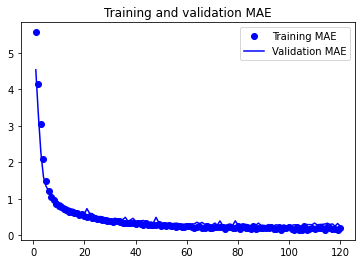

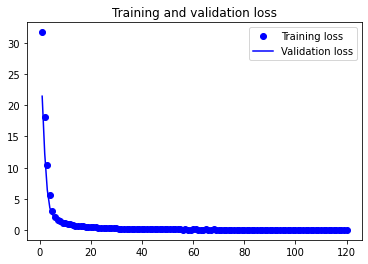

In [30]:
mae = history.history['mae']
val_mae = history.history['val_mae']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(mae) + 1)

plt.plot(epochs, mae, 'bo', label='Training MAE')
plt.plot(epochs, val_mae, 'b', label='Validation MAE')
plt.title('Training and validation MAE')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## K-fold cross validation

In [31]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(input_shape,)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model


In [32]:
k = 5
num_val_samples = len(trainX) // k

In [33]:
all_scores = []
for i in range(k):
    print('Processing Fold', i)
    val_data = trainX_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = trainY[i * num_val_samples: (i + 1) * num_val_samples]

    partial_train_data = np.concatenate(
        [trainX_scaled[:i * num_val_samples],
         trainX_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    model.fit(partial_train_data, partial_train_targets,
              epochs=n_epochs, batch_size=n_batch_size, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    print('MAE: ' + str(val_mae))
    print('----------------------')

Processing Fold 0
MAE: 0.33208516240119934
----------------------
Processing Fold 1
MAE: 0.30574724078178406
----------------------
Processing Fold 2
MAE: 0.2582915723323822
----------------------
Processing Fold 3
MAE: 0.39799195528030396
----------------------
Processing Fold 4
MAE: 0.23594661056995392
----------------------


In [34]:
for i, val in enumerate(all_scores):
    print('Fold ' + str(i) +': ' + 'MAE of', val)

Fold 0: MAE of 0.33208516240119934
Fold 1: MAE of 0.30574724078178406
Fold 2: MAE of 0.2582915723323822
Fold 3: MAE of 0.39799195528030396
Fold 4: MAE of 0.23594661056995392


In [35]:
print('Mean MAE of all folds: ' + str(np.mean(all_scores)))

Mean MAE of all folds: 0.3060125082731247


In [36]:
all_mae_histories = []
for i in range(k):
    print('Processing Fold', i)
    val_data = trainX_scaled[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = trainY[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [trainX_scaled[:i * num_val_samples],
         trainX_scaled[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [trainY[:i * num_val_samples],
         trainY[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=n_epochs, batch_size=n_batch_size, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

Processing Fold 0
Processing Fold 1
Processing Fold 2
Processing Fold 3
Processing Fold 4


In [37]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(n_epochs)]

len(average_mae_history)

120

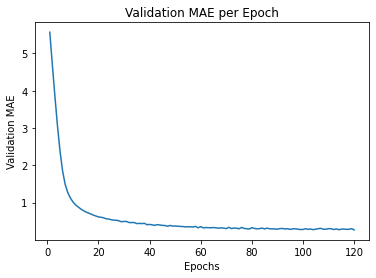

In [38]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.title('Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [39]:
def smooth_curve(points, factor=0.9):
      '''
      Function for smoothing data points

      Args:
          points (float64): Array of floats to be smoothed, numpy array of floats

      Returns:
          Smoothed data points
      '''  
      smoothed_points = []
      for point in points:
        if smoothed_points:
          previous = smoothed_points[-1]
          smoothed_points.append(previous * factor + point * (1 - factor))
        else:
          smoothed_points.append(point)
      return smoothed_points

In [40]:
n_first_observations_to_exclude = 30

smooth_mae_history = smooth_curve(average_mae_history[n_first_observations_to_exclude:])

smooth_mae_history = pd.DataFrame(smooth_mae_history)
smooth_mae_history = smooth_mae_history.set_index(smooth_mae_history.index + n_first_observations_to_exclude)
smooth_mae_history.head()

,0
30,0.495263
31,0.492341
32,0.489629
33,0.487357
34,0.482378


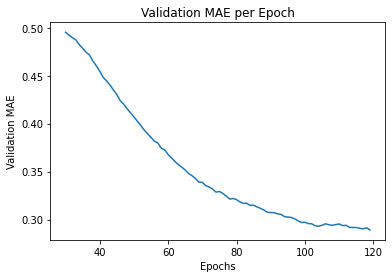

In [41]:
plt.plot(smooth_mae_history)
plt.title('Validation MAE per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [42]:
# Loading the automatically saved model
model_reloaded = load_model(checkpoint_no + '/' + model_name)

# Saving the best model in the correct path and format
root_directory = os.getcwd()
checkpoint_dir = os.path.join(root_directory, checkpoint_no)
model_name_temp = os.path.join(checkpoint_dir, model_name + '.h5')
model_reloaded.save(model_name_temp)

# Deletion of the automatically created folder under Model Checkpoint File.
folder_name_temp = os.path.join(checkpoint_dir, model_name)
shutil.rmtree(folder_name_temp, ignore_errors=True)

In [43]:
best_model = load_model(model_name_temp)

In [44]:
test_loss, test_mae = best_model.evaluate(testX_scaled,
                                          testY,
                                          steps=n_test_steps)
print()
print('Test MAE:', test_mae)

1/1 [==============================] - 0s 124ms/step - loss: 0.1210 - mae: 0.2594

Test MAE: 0.25938892364501953


In [45]:
X = scaler.transform(df[features])

In [46]:
pred = model.predict(X)

36/36 [==============================] - 0s 1ms/step


In [47]:
df_Y = pd.DataFrame(df[target])
df_pred = pd.DataFrame(model.predict(X))

df_Y.reset_index(drop=True, inplace=True)
df_pred.reset_index(drop=True, inplace=True)

df_results = pd.concat([df_Y, df_pred], axis=1)
df_results.columns = ['Actual', 'Predicted']

df_results

36/36 [==============================] - 0s 2ms/step


,Actual,Predicted
0,6.129050,6.241508
1,6.720220,6.620414
2,7.364547,7.080705
3,6.591674,6.583622
4,6.143370,6.039638
...,...,...
1127,6.907755,6.262021
1128,6.683361,6.685207
1129,6.444131,6.639862
1130,6.309900,5.839086


In [48]:
metrics.r2_score(df[target], pred)

0.7947329178969375

In [49]:
print('Mean Absolute Error:', metrics.mean_absolute_error(df[target], pred))
print('Mean Squared Error:', metrics.mean_squared_error(df[target], pred))
print('Root Mean Squared Error:', metrics.mean_squared_error(df[target], pred, squared=False))
print('Mean Absolute Percentage Error:', metrics.mean_absolute_percentage_error(df[target], pred))

Mean Absolute Error: 0.19531016628954082
Mean Squared Error: 0.07989000616980119
Root Mean Squared Error: 0.2826482021343868
Mean Absolute Percentage Error: 0.02869299088967197


## Random Search with KFold cross validation

In [50]:
from random import shuffle
from random import randint
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import time
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

import gc

In [51]:
df = pd.read_csv('data/laptop_train.csv')

In [52]:
from tensorflow import keras

def create_model( nl1=1, nl2=1,  nl3=1, 
                 nn1=1000, nn2=500, nn3 = 200, lr=0.01, momentum = 0.9,  decay=0., l1=0.01, l2=0.01,
                act = 'relu', dropout=0, input_shape=1000, output_shape=1):
    
    opt = keras.optimizers.SGD(lr=lr, momentum=momentum)
    reg = keras.regularizers.l1_l2(l1=l1, l2=l2)
                                                     
    model = models.Sequential()
    
    # for the firt layer we need to specify the input dimensions
    first=True
    
    for i in range(nl1):
        if first:
            model.add(layers.Dense(nn1, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(layers.Dense(nn1, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(layers.Dropout(dropout))
            
    for i in range(nl2):
        if first:
            model.add(layers.Dense(nn2, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(layers.Dense(nn2, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(layers.Dropout(dropout))
            
    for i in range(nl3):
        if first:
            model.add(layers.Dense(nn3, input_dim=input_shape, activation=act, kernel_regularizer=reg))
            first=False
        else: 
            model.add(layers.Dense(nn3, activation=act, kernel_regularizer=reg))
        if dropout!=0:
            model.add(layers.Dropout(dropout))
            
    model.add(layers.Dense(1))
    model.compile(loss='mse', optimizer=opt, metrics=['mae'],)
    return model

In [53]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from keras.wrappers.scikit_learn import KerasRegressor

class SScaler(StandardScaler):
  def fit_transform(self, X, y=None):
    print(len(X))
    return super().fit_transform(X,y)

pipe = Pipeline([
    ('sc', StandardScaler()),
    ('kr', KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=1))
])

<ipython-input-53-e6235ae88227>:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('kr', KerasRegressor(build_fn=create_model, epochs=100, batch_size=32, verbose=1))


In [57]:
lr=[1e-2, 1e-3, 1e-4]
decay=[1e-6,1e-9,0]

# activation
activation=['relu']

# numbers of layers
nl1 = [0,1,2,3]
nl2 = [0,1,2,3]
nl3 = [0,1,2,3]

# neurons in each layer
nn1=[300,700,1400, 2100,]
nn2=[100,400,800]
nn3=[50,150,300]

# dropout and regularisation
dropout = [0, 0.1, 0.2, 0.3]
l1 = [0, 0.1, 0.05, 0.01, 0.003, 0.001,0.0001]
l2 = [0, 0.1, 0.05, 0.01, 0.003, 0.001,0.0001]

# momentum
momentum = [0.1, 0.3, 0.5, 0.7, 0.9]

# dictionary summary
param_grid = dict(
                    kr__nl1=nl1, kr__nl2=nl2, kr__nl3=nl3, kr__nn1=nn1, kr__nn2=nn2, kr__nn3=nn3,
                    kr__act=activation, kr__l1=l1, kr__l2=l2, kr__lr=lr, kr__decay=decay, kr__dropout=dropout, kr__momentum=momentum,
                    kr__input_shape=[x.shape[1]],
                 )

In [58]:
from sklearn.model_selection import cross_val_score, KFold

grid = RandomizedSearchCV(estimator=pipe, cv=KFold(3), param_distributions=param_grid, 
                          verbose=20,  n_iter=50, n_jobs=1)

In [59]:
grid_result = grid.fit(x.to_numpy(), y)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START kr__act=relu, kr__decay=1e-09, kr__dropout=0.2, kr__input_shape=17, kr__l1=0.1, kr__l2=0.001, kr__lr=0.0001, kr__momentum=0.7, kr__nl1=0, kr__nl2=2, kr__nl3=2, kr__nn1=300, kr__nn2=100, kr__nn3=150
Epoch 1/100


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 421.5717 - mae: 6.5307
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 407.5681 - mae: 5.6821
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 392.0526 - mae: 4.4539
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 377.5861 - mae: 2.8499
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 369.1164 - mae: 1.8769
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 364.5188 - mae: 1.7184
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 360.4908 - mae: 1.6258
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 356.4300 - mae: 1.6067
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 352.3819 - mae: 1.5413
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 348.3054 - mae: 1.4677
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 421.2933 - mae: 6.4085
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 405.5049 - mae: 5.3540
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 388.5904 - mae: 3.8194
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 375.5286 - mae: 2.2217
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 369.6766 - mae: 1.7021
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 364.9649 - mae: 1.5050
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 361.3422 - mae: 1.5382
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 357.1609 - mae: 1.4433
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 353.3150 - mae: 1.4208
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 349.4281 - mae: 1.4008
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 422.6519 - mae: 6.4356
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 406.5225 - mae: 5.3658
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 389.4014 - mae: 3.8122
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 376.0337 - mae: 2.1479
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 370.3262 - mae: 1.6454
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 365.7663 - mae: 1.4519
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 361.9290 - mae: 1.4238
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 357.9272 - mae: 1.4119
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 353.8847 - mae: 1.3329
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 349.9236 - mae: 1.2868
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 34ms/step - loss: 166.2025 - mae: 3.0775
Epoch 2/100
24/24 [==============================] - 1s 35ms/step - loss: 137.0589 - mae: 0.7093
Epoch 3/100
24/24 [==============================] - 1s 34ms/step - loss: 123.6860 - mae: 0.6059
Epoch 4/100
24/24 [==============================] - 1s 33ms/step - loss: 111.6926 - mae: 0.5727
Epoch 5/100
24/24 [==============================] - 1s 32ms/step - loss: 100.8053 - mae: 0.5391
Epoch 6/100
24/24 [==============================] - 1s 33ms/step - loss: 90.9356 - mae: 0.5267
Epoch 7/100
24/24 [==============================] - 1s 32ms/step - loss: 82.0039 - mae: 0.5087
Epoch 8/100
24/24 [==============================] - 1s 33ms/step - loss: 73.8722 - mae: 0.4898
Epoch 9/100
24/24 [==============================] - 1s 33ms/step - loss: 66.4862 - mae: 0.4697
Epoch 10/100
24/24 [==============================] - 1s 34ms/step - loss: 59.8528 - mae: 0.4720
Epoch 11/100
24/24 [==========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 32ms/step - loss: 161.3556 - mae: 2.4699
Epoch 2/100
24/24 [==============================] - 1s 32ms/step - loss: 136.5709 - mae: 0.6797
Epoch 3/100
24/24 [==============================] - 1s 33ms/step - loss: 123.2953 - mae: 0.5964
Epoch 4/100
24/24 [==============================] - 1s 31ms/step - loss: 111.3233 - mae: 0.5612
Epoch 5/100
24/24 [==============================] - 1s 32ms/step - loss: 100.4646 - mae: 0.5340
Epoch 6/100
24/24 [==============================] - 1s 32ms/step - loss: 90.6379 - mae: 0.5224
Epoch 7/100
24/24 [==============================] - 1s 32ms/step - loss: 81.6757 - mae: 0.4837
Epoch 8/100
24/24 [==============================] - 1s 31ms/step - loss: 73.6020 - mae: 0.4675
Epoch 9/100
24/24 [==============================] - 1s 31ms/step - loss: 66.2859 - mae: 0.4761
Epoch 10/100
24/24 [==============================] - 1s 32ms/step - loss: 59.6266 - mae: 0.4707
Epoch 11/100
24/24 [==========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 33ms/step - loss: 162.0036 - mae: 2.5991
Epoch 2/100
24/24 [==============================] - 1s 39ms/step - loss: 136.4848 - mae: 0.6587
Epoch 3/100
24/24 [==============================] - 1s 33ms/step - loss: 123.2425 - mae: 0.5882
Epoch 4/100
24/24 [==============================] - 1s 33ms/step - loss: 111.2503 - mae: 0.5394
Epoch 5/100
24/24 [==============================] - 1s 32ms/step - loss: 100.4076 - mae: 0.5171
Epoch 6/100
24/24 [==============================] - 1s 32ms/step - loss: 90.5329 - mae: 0.4778
Epoch 7/100
24/24 [==============================] - 1s 32ms/step - loss: 81.6509 - mae: 0.4778
Epoch 8/100
24/24 [==============================] - 1s 32ms/step - loss: 73.5994 - mae: 0.4817
Epoch 9/100
24/24 [==============================] - 1s 32ms/step - loss: 66.2280 - mae: 0.4442
Epoch 10/100
24/24 [==============================] - 1s 31ms/step - loss: 59.5710 - mae: 0.4351
Epoch 11/100
24/24 [==========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 1s 3ms/step - loss: 42.7949 - mae: 3.7931
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 23.5362 - mae: 1.0051
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 21.1625 - mae: 0.4063
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 20.0478 - mae: 0.3023
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 19.0633 - mae: 0.2687
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 18.1398 - mae: 0.2460
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 17.2679 - mae: 0.2341
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 16.4415 - mae: 0.2279
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 15.6532 - mae: 0.2193
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 14.9057 - mae: 0.2162
Epoch 11/100
24/24 [=============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 40.4023 - mae: 3.5068
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 22.8192 - mae: 0.7609
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 21.1109 - mae: 0.4163
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 20.0202 - mae: 0.3391
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 19.0196 - mae: 0.2882
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 18.0978 - mae: 0.2679
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 17.2257 - mae: 0.2547
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 16.3985 - mae: 0.2444
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 15.6128 - mae: 0.2394
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 14.8632 - mae: 0.2269
Epoch 11/100
24/24 [==============================] - 0s 3ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 44.0601 - mae: 3.9685
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 23.4608 - mae: 1.0206
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 21.0495 - mae: 0.3742
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 19.9635 - mae: 0.2930
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 18.9894 - mae: 0.2682
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 18.0746 - mae: 0.2559
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 17.2011 - mae: 0.2374
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 16.3753 - mae: 0.2279
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 15.5901 - mae: 0.2206
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 14.8442 - mae: 0.2153
Epoch 11/100
24/24 [==============================] - 0s 3ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 171.3493 - mae: 4.2677
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 145.7639 - mae: 0.9924
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 140.4755 - mae: 0.8019
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 135.5262 - mae: 0.7080
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 130.7578 - mae: 0.6510
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 126.1105 - mae: 0.6030
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 121.5729 - mae: 0.5659
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 117.1376 - mae: 0.5390
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 112.7923 - mae: 0.5150
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 108.5416 - mae: 0.4916
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 165.7300 - mae: 3.6777
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 145.0533 - mae: 1.0588
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 139.5528 - mae: 0.8001
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 134.5697 - mae: 0.6770
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 129.8053 - mae: 0.6116
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 125.1700 - mae: 0.5714
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 120.6449 - mae: 0.5365
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 116.2179 - mae: 0.5093
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 111.8839 - mae: 0.4864
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 107.6405 - mae: 0.4645
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 164.6244 - mae: 3.4215
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 146.3350 - mae: 1.2051
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 140.6186 - mae: 0.9215
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 135.5128 - mae: 0.7721
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 130.6834 - mae: 0.6863
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 126.0209 - mae: 0.6255
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 121.4781 - mae: 0.5780
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 117.0384 - mae: 0.5449
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 112.6953 - mae: 0.5200
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 108.4438 - mae: 0.4934
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 14ms/step - loss: 17.7403 - mae: 3.3617
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 2.8111 - mae: 1.0718
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 2.2691 - mae: 0.8978
Epoch 4/100
24/24 [==============================] - 0s 16ms/step - loss: 2.0854 - mae: 0.8388
Epoch 5/100
24/24 [==============================] - 0s 15ms/step - loss: 2.0906 - mae: 0.8451
Epoch 6/100
24/24 [==============================] - 0s 15ms/step - loss: 1.9564 - mae: 0.7817
Epoch 7/100
24/24 [==============================] - 0s 15ms/step - loss: 1.9138 - mae: 0.7784
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 1.9021 - mae: 0.7624
Epoch 9/100
24/24 [==============================] - 0s 14ms/step - loss: 1.9122 - mae: 0.7877
Epoch 10/100
24/24 [==============================] - 0s 14ms/step - loss: 1.7785 - mae: 0.7207
Epoch 11/100
24/24 [==============================] - 0s 14m

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 15ms/step - loss: 24.4607 - mae: 4.2280
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 2.7848 - mae: 1.0829
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 2.3600 - mae: 0.9428
Epoch 4/100
24/24 [==============================] - 0s 15ms/step - loss: 2.4089 - mae: 0.9573
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 2.1699 - mae: 0.8518
Epoch 6/100
24/24 [==============================] - 0s 15ms/step - loss: 2.1737 - mae: 0.8613
Epoch 7/100
24/24 [==============================] - 0s 15ms/step - loss: 2.0569 - mae: 0.8303
Epoch 8/100
24/24 [==============================] - 0s 15ms/step - loss: 1.9764 - mae: 0.8043
Epoch 9/100
24/24 [==============================] - 0s 15ms/step - loss: 1.9621 - mae: 0.7846
Epoch 10/100
24/24 [==============================] - 0s 15ms/step - loss: 1.8819 - mae: 0.7660
Epoch 11/100
24/24 [==============================] - 0s 14m

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 14ms/step - loss: 19.9813 - mae: 3.6733
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 2.8888 - mae: 1.1144
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 2.3886 - mae: 0.9500
Epoch 4/100
24/24 [==============================] - 0s 14ms/step - loss: 2.0569 - mae: 0.8237
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 2.0459 - mae: 0.8183
Epoch 6/100
24/24 [==============================] - 0s 15ms/step - loss: 1.9678 - mae: 0.7989
Epoch 7/100
24/24 [==============================] - 0s 14ms/step - loss: 1.8791 - mae: 0.7590
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 1.7972 - mae: 0.7210
Epoch 9/100
24/24 [==============================] - 0s 14ms/step - loss: 1.7696 - mae: 0.7021
Epoch 10/100
24/24 [==============================] - 0s 13ms/step - loss: 1.7808 - mae: 0.7215
Epoch 11/100
24/24 [==============================] - 0s 13m

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 13ms/step - loss: 1697.8704 - mae: 6.6767
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 1675.5251 - mae: 6.2741
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 1653.9259 - mae: 5.8968
Epoch 4/100
24/24 [==============================] - 0s 14ms/step - loss: 1632.7612 - mae: 5.5177
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 1611.9810 - mae: 5.1383
Epoch 6/100
24/24 [==============================] - 0s 14ms/step - loss: 1591.5635 - mae: 4.7477
Epoch 7/100
24/24 [==============================] - 0s 14ms/step - loss: 1571.5376 - mae: 4.3569
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 1551.8542 - mae: 3.9549
Epoch 9/100
24/24 [==============================] - 0s 14ms/step - loss: 1532.7061 - mae: 3.5649
Epoch 10/100
24/24 [==============================] - 0s 13ms/step - loss: 1514.0781 - mae: 3.2049
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 13ms/step - loss: 1700.6388 - mae: 6.8252
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 1677.9049 - mae: 6.4029
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 1655.7928 - mae: 5.9918
Epoch 4/100
24/24 [==============================] - 0s 14ms/step - loss: 1634.3280 - mae: 5.5937
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 1613.2355 - mae: 5.1906
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 1592.5544 - mae: 4.7782
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 1572.3793 - mae: 4.3733
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 1552.5237 - mae: 3.9503
Epoch 9/100
24/24 [==============================] - 0s 13ms/step - loss: 1533.1846 - mae: 3.5362
Epoch 10/100
24/24 [==============================] - 0s 14ms/step - loss: 1514.5320 - mae: 3.1607
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 13ms/step - loss: 1695.9448 - mae: 6.5277
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 1673.5972 - mae: 6.1123
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 1652.0400 - mae: 5.7252
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 1630.8682 - mae: 5.3323
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 1610.1106 - mae: 4.9361
Epoch 6/100
24/24 [==============================] - 0s 14ms/step - loss: 1589.7510 - mae: 4.5359
Epoch 7/100
24/24 [==============================] - 0s 14ms/step - loss: 1569.9351 - mae: 4.1464
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 1550.4196 - mae: 3.7415
Epoch 9/100
24/24 [==============================] - 0s 13ms/step - loss: 1531.4176 - mae: 3.3515
Epoch 10/100
24/24 [==============================] - 0s 13ms/step - loss: 1512.9303 - mae: 2.9914
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 42ms/step - loss: 678.7297 - mae: 6.5220
Epoch 2/100
24/24 [==============================] - 1s 42ms/step - loss: 670.6145 - mae: 5.9952
Epoch 3/100
24/24 [==============================] - 1s 41ms/step - loss: 662.5371 - mae: 5.4166
Epoch 4/100
24/24 [==============================] - 1s 41ms/step - loss: 654.6405 - mae: 4.7792
Epoch 5/100
24/24 [==============================] - 1s 41ms/step - loss: 647.0825 - mae: 4.0764
Epoch 6/100
24/24 [==============================] - 1s 42ms/step - loss: 640.2881 - mae: 3.3285
Epoch 7/100
24/24 [==============================] - 1s 41ms/step - loss: 634.7583 - mae: 2.6105
Epoch 8/100
24/24 [==============================] - 1s 41ms/step - loss: 630.6044 - mae: 2.0372
Epoch 9/100
24/24 [==============================] - 1s 40ms/step - loss: 627.5544 - mae: 1.6574
Epoch 10/100
24/24 [==============================] - 1s 41ms/step - loss: 625.1922 - mae: 1.4428
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 42ms/step - loss: 682.9905 - mae: 6.8175
Epoch 2/100
24/24 [==============================] - 1s 41ms/step - loss: 678.2899 - mae: 6.5853
Epoch 3/100
24/24 [==============================] - 1s 41ms/step - loss: 673.8400 - mae: 6.3631
Epoch 4/100
24/24 [==============================] - 1s 41ms/step - loss: 669.2350 - mae: 6.1179
Epoch 5/100
24/24 [==============================] - 1s 41ms/step - loss: 664.3383 - mae: 5.8361
Epoch 6/100
24/24 [==============================] - 1s 40ms/step - loss: 659.0469 - mae: 5.5011
Epoch 7/100
24/24 [==============================] - 1s 41ms/step - loss: 653.3422 - mae: 5.1023
Epoch 8/100
24/24 [==============================] - 1s 41ms/step - loss: 647.2922 - mae: 4.6274
Epoch 9/100
24/24 [==============================] - 1s 41ms/step - loss: 641.1183 - mae: 4.0756
Epoch 10/100
24/24 [==============================] - 1s 42ms/step - loss: 635.1950 - mae: 3.4656
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 43ms/step - loss: 680.6892 - mae: 6.6447
Epoch 2/100
24/24 [==============================] - 1s 43ms/step - loss: 674.3308 - mae: 6.2747
Epoch 3/100
24/24 [==============================] - 1s 40ms/step - loss: 667.7245 - mae: 5.8569
Epoch 4/100
24/24 [==============================] - 1s 41ms/step - loss: 660.7612 - mae: 5.3691
Epoch 5/100
24/24 [==============================] - 1s 41ms/step - loss: 653.4789 - mae: 4.7951
Epoch 6/100
24/24 [==============================] - 1s 41ms/step - loss: 646.2015 - mae: 4.1296
Epoch 7/100
24/24 [==============================] - 1s 41ms/step - loss: 639.5125 - mae: 3.4162
Epoch 8/100
24/24 [==============================] - 1s 42ms/step - loss: 633.9111 - mae: 2.7162
Epoch 9/100
24/24 [==============================] - 1s 41ms/step - loss: 629.5714 - mae: 2.1160
Epoch 10/100
24/24 [==============================] - 1s 40ms/step - loss: 626.3302 - mae: 1.6905
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 10ms/step - loss: 50.0472 - mae: 2.5910
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 37.8360 - mae: 0.6242
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 36.9482 - mae: 0.5219
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 36.1814 - mae: 0.4832
Epoch 5/100
24/24 [==============================] - 0s 11ms/step - loss: 35.4824 - mae: 0.4713
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 34.7488 - mae: 0.4474
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 34.0387 - mae: 0.4257
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 33.3582 - mae: 0.4235
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 32.6975 - mae: 0.4215
Epoch 10/100
24/24 [==============================] - 0s 9ms/step - loss: 32.0027 - mae: 0.3947
Epoch 11/100
24/24 [==============================] - 0

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 9ms/step - loss: 44.9297 - mae: 1.8588
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 38.4102 - mae: 0.7969
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 37.3275 - mae: 0.6436
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 36.4324 - mae: 0.5475
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 35.7203 - mae: 0.5298
Epoch 6/100
24/24 [==============================] - 0s 11ms/step - loss: 34.9636 - mae: 0.5029
Epoch 7/100
24/24 [==============================] - 0s 11ms/step - loss: 34.2521 - mae: 0.4803
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 33.5545 - mae: 0.4613
Epoch 9/100
24/24 [==============================] - 0s 11ms/step - loss: 32.9019 - mae: 0.4694
Epoch 10/100
24/24 [==============================] - 0s 9ms/step - loss: 32.2130 - mae: 0.4516
Epoch 11/100
24/24 [==============================] -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 9ms/step - loss: 47.1056 - mae: 2.1938
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 38.0795 - mae: 0.7016
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 37.1423 - mae: 0.6015
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 36.3448 - mae: 0.5432
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 35.5781 - mae: 0.5029
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 34.8186 - mae: 0.4621
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 34.1357 - mae: 0.4496
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 33.4255 - mae: 0.4235
Epoch 9/100
24/24 [==============================] - 0s 9ms/step - loss: 32.7802 - mae: 0.4422
Epoch 10/100
24/24 [==============================] - 0s 11ms/step - loss: 32.0940 - mae: 0.4230
Epoch 11/100
24/24 [==============================] - 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 17ms/step - loss: 243.1504 - mae: 1.5070
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 220.8971 - mae: 0.7112
Epoch 3/100
24/24 [==============================] - 0s 17ms/step - loss: 203.1825 - mae: 0.6161
Epoch 4/100
24/24 [==============================] - 0s 17ms/step - loss: 186.2957 - mae: 0.5662
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 170.1734 - mae: 0.5189
Epoch 6/100
24/24 [==============================] - 0s 17ms/step - loss: 154.7809 - mae: 0.4665
Epoch 7/100
24/24 [==============================] - 0s 16ms/step - loss: 140.1626 - mae: 0.4287
Epoch 8/100
24/24 [==============================] - 0s 17ms/step - loss: 126.3369 - mae: 0.4366
Epoch 9/100
24/24 [==============================] - 0s 16ms/step - loss: 113.2171 - mae: 0.4141
Epoch 10/100
24/24 [==============================] - 0s 16ms/step - loss: 100.8672 - mae: 0.4056
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 16ms/step - loss: 244.6839 - mae: 1.6460
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 221.2301 - mae: 0.7203
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 203.5099 - mae: 0.6287
Epoch 4/100
24/24 [==============================] - 0s 16ms/step - loss: 186.5666 - mae: 0.5424
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 170.4348 - mae: 0.4964
Epoch 6/100
24/24 [==============================] - 0s 18ms/step - loss: 155.1156 - mae: 0.4839
Epoch 7/100
24/24 [==============================] - 0s 15ms/step - loss: 140.4880 - mae: 0.4486
Epoch 8/100
24/24 [==============================] - 0s 16ms/step - loss: 126.6296 - mae: 0.4258
Epoch 9/100
24/24 [==============================] - 0s 16ms/step - loss: 113.5265 - mae: 0.4240
Epoch 10/100
24/24 [==============================] - 0s 16ms/step - loss: 101.1238 - mae: 0.3841
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 17ms/step - loss: 244.2220 - mae: 1.5880
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 221.1688 - mae: 0.6928
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 203.4031 - mae: 0.5785
Epoch 4/100
24/24 [==============================] - 0s 17ms/step - loss: 186.5764 - mae: 0.5391
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 170.4358 - mae: 0.4880
Epoch 6/100
24/24 [==============================] - 0s 16ms/step - loss: 155.1035 - mae: 0.4704
Epoch 7/100
24/24 [==============================] - 0s 18ms/step - loss: 140.4917 - mae: 0.4583
Epoch 8/100
24/24 [==============================] - 0s 16ms/step - loss: 126.5814 - mae: 0.3991
Epoch 9/100
24/24 [==============================] - 0s 17ms/step - loss: 113.4711 - mae: 0.3920
Epoch 10/100
24/24 [==============================] - 0s 16ms/step - loss: 101.0915 - mae: 0.3857
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 3s 94ms/step - loss: 978.1049 - mae: 5.4156
Epoch 2/100
24/24 [==============================] - 2s 92ms/step - loss: 927.0676 - mae: 1.4835
Epoch 3/100
24/24 [==============================] - 2s 92ms/step - loss: 903.5443 - mae: 1.2355
Epoch 4/100
24/24 [==============================] - 2s 92ms/step - loss: 880.9467 - mae: 1.1400
Epoch 5/100
24/24 [==============================] - 2s 91ms/step - loss: 858.6844 - mae: 1.0628
Epoch 6/100
24/24 [==============================] - 2s 92ms/step - loss: 836.7850 - mae: 0.9763
Epoch 7/100
24/24 [==============================] - 2s 92ms/step - loss: 815.4338 - mae: 1.0137
Epoch 8/100
24/24 [==============================] - 2s 92ms/step - loss: 794.2026 - mae: 0.9422
Epoch 9/100
24/24 [==============================] - 2s 93ms/step - loss: 773.3810 - mae: 0.9331
Epoch 10/100
24/24 [==============================] - 2s 92ms/step - loss: 752.6437 - mae: 0.8894
Epoch 11/100
24/24 [=========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 3s 92ms/step - loss: 975.1499 - mae: 4.9520
Epoch 2/100
24/24 [==============================] - 2s 91ms/step - loss: 927.0823 - mae: 1.3740
Epoch 3/100
24/24 [==============================] - 2s 91ms/step - loss: 903.7786 - mae: 1.1941
Epoch 4/100
24/24 [==============================] - 2s 92ms/step - loss: 881.3450 - mae: 1.1302
Epoch 5/100
24/24 [==============================] - 2s 92ms/step - loss: 859.0204 - mae: 1.0138
Epoch 6/100
24/24 [==============================] - 2s 91ms/step - loss: 837.2526 - mae: 0.9910
Epoch 7/100
24/24 [==============================] - 2s 91ms/step - loss: 815.7761 - mae: 0.9805
Epoch 8/100
24/24 [==============================] - 2s 91ms/step - loss: 794.5884 - mae: 0.9298
Epoch 9/100
24/24 [==============================] - 2s 92ms/step - loss: 773.6403 - mae: 0.8862
Epoch 10/100
24/24 [==============================] - 2s 93ms/step - loss: 753.2134 - mae: 0.9439
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 3s 92ms/step - loss: 973.2117 - mae: 4.7110
Epoch 2/100
24/24 [==============================] - 2s 95ms/step - loss: 927.2012 - mae: 1.4284
Epoch 3/100
24/24 [==============================] - 2s 95ms/step - loss: 903.7740 - mae: 1.2385
Epoch 4/100
24/24 [==============================] - 3s 140ms/step - loss: 881.1380 - mae: 1.0898
Epoch 5/100
24/24 [==============================] - 2s 93ms/step - loss: 859.0327 - mae: 1.0625
Epoch 6/100
24/24 [==============================] - 2s 94ms/step - loss: 837.2732 - mae: 1.0573
Epoch 7/100
24/24 [==============================] - 2s 94ms/step - loss: 815.7490 - mae: 1.0190
Epoch 8/100
24/24 [==============================] - 2s 94ms/step - loss: 794.4967 - mae: 0.9520
Epoch 9/100
24/24 [==============================] - 2s 94ms/step - loss: 773.5698 - mae: 0.9168
Epoch 10/100
24/24 [==============================] - 2s 93ms/step - loss: 752.9695 - mae: 0.8913
Epoch 11/100
24/24 [====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 5s 154ms/step - loss: 527.5048 - mae: 3.2059
Epoch 2/100
24/24 [==============================] - 4s 153ms/step - loss: 505.3885 - mae: 0.6010
Epoch 3/100
24/24 [==============================] - 4s 154ms/step - loss: 498.7965 - mae: 0.4825
Epoch 4/100
24/24 [==============================] - 4s 154ms/step - loss: 492.3594 - mae: 0.4268
Epoch 5/100
24/24 [==============================] - 5s 194ms/step - loss: 485.9944 - mae: 0.3889
Epoch 6/100
24/24 [==============================] - 5s 211ms/step - loss: 479.6877 - mae: 0.3634
Epoch 7/100
24/24 [==============================] - 5s 190ms/step - loss: 473.4293 - mae: 0.3367
Epoch 8/100
24/24 [==============================] - 5s 189ms/step - loss: 467.2184 - mae: 0.3185
Epoch 9/100
24/24 [==============================] - 4s 151ms/step - loss: 461.0503 - mae: 0.2997
Epoch 10/100
24/24 [==============================] - 4s 152ms/step - loss: 454.9283 - mae: 0.2869
Epoch 11/100
24/24 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 5s 156ms/step - loss: 530.8335 - mae: 3.6654
Epoch 2/100
24/24 [==============================] - 4s 157ms/step - loss: 505.3161 - mae: 0.6426
Epoch 3/100
24/24 [==============================] - 4s 155ms/step - loss: 498.6381 - mae: 0.4848
Epoch 4/100
24/24 [==============================] - 4s 157ms/step - loss: 492.2014 - mae: 0.4295
Epoch 5/100
24/24 [==============================] - 5s 208ms/step - loss: 485.8305 - mae: 0.3849
Epoch 6/100
24/24 [==============================] - 4s 157ms/step - loss: 479.5225 - mae: 0.3522
Epoch 7/100
24/24 [==============================] - 4s 155ms/step - loss: 473.2720 - mae: 0.3343
Epoch 8/100
24/24 [==============================] - 4s 155ms/step - loss: 467.0570 - mae: 0.3098
Epoch 9/100
24/24 [==============================] - 4s 155ms/step - loss: 460.8886 - mae: 0.2913
Epoch 10/100
24/24 [==============================] - 4s 155ms/step - loss: 454.7697 - mae: 0.2796
Epoch 11/100
24/24 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 5s 158ms/step - loss: 535.4051 - mae: 4.3280
Epoch 2/100
24/24 [==============================] - 4s 156ms/step - loss: 505.3840 - mae: 0.6427
Epoch 3/100
24/24 [==============================] - 4s 160ms/step - loss: 498.6811 - mae: 0.4701
Epoch 4/100
24/24 [==============================] - 4s 159ms/step - loss: 492.2347 - mae: 0.3965
Epoch 5/100
24/24 [==============================] - 5s 205ms/step - loss: 485.8753 - mae: 0.3583
Epoch 6/100
24/24 [==============================] - 4s 153ms/step - loss: 479.5743 - mae: 0.3307
Epoch 7/100
24/24 [==============================] - 4s 154ms/step - loss: 473.3257 - mae: 0.3145
Epoch 8/100
24/24 [==============================] - 4s 157ms/step - loss: 467.1172 - mae: 0.2968
Epoch 9/100
24/24 [==============================] - 4s 154ms/step - loss: 460.9580 - mae: 0.2863
Epoch 10/100
24/24 [==============================] - 4s 154ms/step - loss: 454.8404 - mae: 0.2756
Epoch 11/100
24/24 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 7ms/step - loss: 63.5609 - mae: 6.2621
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 35.7813 - mae: 3.0510
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 25.0967 - mae: 0.9204
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 24.5737 - mae: 0.7295
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 24.3149 - mae: 0.6276
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 24.1570 - mae: 0.5683
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 24.0463 - mae: 0.5314
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 23.9557 - mae: 0.5001
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 23.8759 - mae: 0.4819
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 23.8032 - mae: 0.4628
Epoch 11/100
24/24 [==============================] - 0s 7ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 7ms/step - loss: 63.0464 - mae: 6.2120
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 32.1894 - mae: 2.4267
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 24.8758 - mae: 0.8225
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 24.4854 - mae: 0.6808
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 24.2817 - mae: 0.6060
Epoch 6/100
24/24 [==============================] - 0s 10ms/step - loss: 24.1449 - mae: 0.5596
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 24.0349 - mae: 0.5202
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 23.9456 - mae: 0.4932
Epoch 9/100
24/24 [==============================] - 0s 10ms/step - loss: 23.8672 - mae: 0.4713
Epoch 10/100
24/24 [==============================] - 0s 11ms/step - loss: 23.7927 - mae: 0.4518
Epoch 11/100
24/24 [==============================] - 0

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 7ms/step - loss: 58.6430 - mae: 5.8149
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 27.6673 - mae: 1.6002
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 24.7151 - mae: 0.7780
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 24.3608 - mae: 0.6371
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 24.1666 - mae: 0.5578
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 24.0412 - mae: 0.5083
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 23.9444 - mae: 0.4748
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 23.8623 - mae: 0.4508
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 23.7890 - mae: 0.4323
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 23.7189 - mae: 0.4155
Epoch 11/100
24/24 [==============================] - 0s 7ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 3s 68ms/step - loss: 398.5237 - mae: 6.2992
Epoch 2/100
24/24 [==============================] - 2s 66ms/step - loss: 383.4135 - mae: 4.9975
Epoch 3/100
24/24 [==============================] - 2s 67ms/step - loss: 367.7019 - mae: 3.0189
Epoch 4/100
24/24 [==============================] - 2s 67ms/step - loss: 360.8947 - mae: 1.8416
Epoch 5/100
24/24 [==============================] - 2s 69ms/step - loss: 359.0974 - mae: 1.5661
Epoch 6/100
24/24 [==============================] - 2s 66ms/step - loss: 358.0013 - mae: 1.5204
Epoch 7/100
24/24 [==============================] - 2s 68ms/step - loss: 357.0308 - mae: 1.4395
Epoch 8/100
24/24 [==============================] - 2s 66ms/step - loss: 355.8464 - mae: 1.3561
Epoch 9/100
24/24 [==============================] - 2s 66ms/step - loss: 355.1029 - mae: 1.3787
Epoch 10/100
24/24 [==============================] - 2s 66ms/step - loss: 353.9282 - mae: 1.2921
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 3s 75ms/step - loss: 402.8234 - mae: 6.6540
Epoch 2/100
24/24 [==============================] - 2s 72ms/step - loss: 392.2015 - mae: 5.8563
Epoch 3/100
24/24 [==============================] - 2s 74ms/step - loss: 378.5991 - mae: 4.5704
Epoch 4/100
24/24 [==============================] - 2s 74ms/step - loss: 365.6192 - mae: 2.7976
Epoch 5/100
24/24 [==============================] - 2s 72ms/step - loss: 360.2333 - mae: 1.8955
Epoch 6/100
24/24 [==============================] - 2s 74ms/step - loss: 358.8368 - mae: 1.6955
Epoch 7/100
24/24 [==============================] - 2s 74ms/step - loss: 357.4067 - mae: 1.5972
Epoch 8/100
24/24 [==============================] - 2s 70ms/step - loss: 356.5378 - mae: 1.5347
Epoch 9/100
24/24 [==============================] - 2s 74ms/step - loss: 355.1692 - mae: 1.4394
Epoch 10/100
24/24 [==============================] - 2s 73ms/step - loss: 354.4103 - mae: 1.4247
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 3s 71ms/step - loss: 401.1753 - mae: 6.5290
Epoch 2/100
24/24 [==============================] - 2s 71ms/step - loss: 390.3509 - mae: 5.6967
Epoch 3/100
24/24 [==============================] - 2s 71ms/step - loss: 375.6128 - mae: 4.2267
Epoch 4/100
24/24 [==============================] - 2s 72ms/step - loss: 363.0414 - mae: 2.3423
Epoch 5/100
24/24 [==============================] - 2s 70ms/step - loss: 358.9921 - mae: 1.6199
Epoch 6/100
24/24 [==============================] - 2s 72ms/step - loss: 357.7536 - mae: 1.4925
Epoch 7/100
24/24 [==============================] - 2s 72ms/step - loss: 356.9384 - mae: 1.4836
Epoch 8/100
24/24 [==============================] - 2s 72ms/step - loss: 355.7448 - mae: 1.4024
Epoch 9/100
24/24 [==============================] - 2s 74ms/step - loss: 354.7290 - mae: 1.3451
Epoch 10/100
24/24 [==============================] - 2s 71ms/step - loss: 353.8887 - mae: 1.3168
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 68.1131 - mae: 6.4183
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 43.2099 - mae: 3.7175
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 28.6901 - mae: 1.1835
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 27.2894 - mae: 0.7657
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 27.0130 - mae: 0.6598
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 26.8566 - mae: 0.5937
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 26.7597 - mae: 0.5689
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 26.6444 - mae: 0.5252
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 26.5625 - mae: 0.5042
Epoch 10/100
24/24 [==============================] - 0s 5ms/step - loss: 26.4894 - mae: 0.4864
Epoch 11/100
24/24 [==============================] - 0s 5ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 71.4446 - mae: 6.6683
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 55.1477 - mae: 5.2637
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 30.2851 - mae: 1.5612
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 27.6001 - mae: 0.8503
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 27.1775 - mae: 0.6698
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 27.0063 - mae: 0.6112
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 26.8837 - mae: 0.5761
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 26.7881 - mae: 0.5417
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 26.7004 - mae: 0.5225
Epoch 10/100
24/24 [==============================] - 0s 5ms/step - loss: 26.6231 - mae: 0.5000
Epoch 11/100
24/24 [==============================] - 0s 5ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 70.0514 - mae: 6.5636
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 56.0187 - mae: 5.3665
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 31.4219 - mae: 1.8356
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 27.3978 - mae: 0.7818
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 27.0056 - mae: 0.5961
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 26.8404 - mae: 0.5304
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 26.7155 - mae: 0.4752
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 26.6259 - mae: 0.4473
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 26.5505 - mae: 0.4278
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 26.4845 - mae: 0.4117
Epoch 11/100
24/24 [==============================] - 0s 5ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 10.7831 - mae: 1.6315
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 4.4866 - mae: 0.6001
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 3.6125 - mae: 0.5068
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 2.9088 - mae: 0.4418
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 2.3610 - mae: 0.4002
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 1.9082 - mae: 0.3584
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 1.5558 - mae: 0.3375
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 1.2720 - mae: 0.3252
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 1.0238 - mae: 0.3012
Epoch 10/100
24/24 [==============================] - 0s 3ms/step - loss: 0.8388 - mae: 0.2986
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 10.8019 - mae: 1.6397
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 4.5251 - mae: 0.6115
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 3.6135 - mae: 0.5174
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 2.9044 - mae: 0.4384
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 2.3708 - mae: 0.3987
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 1.9201 - mae: 0.3629
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 1.5617 - mae: 0.3393
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 1.2684 - mae: 0.3311
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 1.0376 - mae: 0.3163
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.8402 - mae: 0.2926
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 10.7580 - mae: 1.6199
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 4.4609 - mae: 0.5689
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 3.6179 - mae: 0.5034
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 2.9229 - mae: 0.4398
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 2.3717 - mae: 0.3930
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 1.9187 - mae: 0.3477
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 1.5802 - mae: 0.3485
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 1.2717 - mae: 0.3148
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 1.0225 - mae: 0.2830
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.8376 - mae: 0.2964
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 11ms/step - loss: 73.5848 - mae: 5.9627
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 42.9030 - mae: 1.9510
Epoch 3/100
24/24 [==============================] - 0s 12ms/step - loss: 38.2476 - mae: 0.8186
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 37.8014 - mae: 0.6635
Epoch 5/100
24/24 [==============================] - 0s 11ms/step - loss: 37.5410 - mae: 0.5832
Epoch 6/100
24/24 [==============================] - 0s 11ms/step - loss: 37.3577 - mae: 0.5346
Epoch 7/100
24/24 [==============================] - 0s 11ms/step - loss: 37.2074 - mae: 0.5031
Epoch 8/100
24/24 [==============================] - 0s 11ms/step - loss: 37.0714 - mae: 0.4786
Epoch 9/100
24/24 [==============================] - 0s 12ms/step - loss: 36.9430 - mae: 0.4592
Epoch 10/100
24/24 [==============================] - 0s 11ms/step - loss: 36.8225 - mae: 0.4433
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 1s 12ms/step - loss: 77.7944 - mae: 6.3169
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 50.9709 - mae: 3.3230
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 38.5671 - mae: 0.9190
Epoch 4/100
24/24 [==============================] - 0s 12ms/step - loss: 37.9621 - mae: 0.7078
Epoch 5/100
24/24 [==============================] - 0s 12ms/step - loss: 37.6528 - mae: 0.6005
Epoch 6/100
24/24 [==============================] - 0s 12ms/step - loss: 37.4485 - mae: 0.5420
Epoch 7/100
24/24 [==============================] - 0s 11ms/step - loss: 37.2902 - mae: 0.5034
Epoch 8/100
24/24 [==============================] - 0s 12ms/step - loss: 37.1538 - mae: 0.4751
Epoch 9/100
24/24 [==============================] - 0s 11ms/step - loss: 37.0281 - mae: 0.4555
Epoch 10/100
24/24 [==============================] - 0s 11ms/step - loss: 36.9085 - mae: 0.4388
Epoch 11/100
24/24 [===================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 11ms/step - loss: 78.0400 - mae: 6.3379
Epoch 2/100
24/24 [==============================] - 0s 11ms/step - loss: 51.1479 - mae: 3.3190
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 38.4505 - mae: 0.8690
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 37.8880 - mae: 0.6696
Epoch 5/100
24/24 [==============================] - 0s 12ms/step - loss: 37.5931 - mae: 0.5754
Epoch 6/100
24/24 [==============================] - 0s 12ms/step - loss: 37.3885 - mae: 0.5195
Epoch 7/100
24/24 [==============================] - 0s 12ms/step - loss: 37.2317 - mae: 0.4825
Epoch 8/100
24/24 [==============================] - 0s 12ms/step - loss: 37.0942 - mae: 0.4572
Epoch 9/100
24/24 [==============================] - 0s 11ms/step - loss: 36.9689 - mae: 0.4365
Epoch 10/100
24/24 [==============================] - 0s 11ms/step - loss: 36.8508 - mae: 0.4211
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 2s 23ms/step - loss: 116.8160 - mae: 3.2154
Epoch 2/100
24/24 [==============================] - 1s 23ms/step - loss: 87.0018 - mae: 0.5346
Epoch 3/100
24/24 [==============================] - 1s 23ms/step - loss: 74.0625 - mae: 0.5124
Epoch 4/100
24/24 [==============================] - 1s 22ms/step - loss: 63.0790 - mae: 0.5205
Epoch 5/100
24/24 [==============================] - 1s 23ms/step - loss: 53.7279 - mae: 0.5165
Epoch 6/100
24/24 [==============================] - 1s 23ms/step - loss: 45.7743 - mae: 0.5183
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 39.0075 - mae: 0.5164
Epoch 8/100
24/24 [==============================] - 1s 24ms/step - loss: 33.2507 - mae: 0.5183
Epoch 9/100
24/24 [==============================] - 1s 23ms/step - loss: 28.3475 - mae: 0.5187
Epoch 10/100
24/24 [==============================] - 1s 23ms/step - loss: 24.1864 - mae: 0.5211
Epoch 11/100
24/24 [==================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 23ms/step - loss: 113.1497 - mae: 2.7781
Epoch 2/100
24/24 [==============================] - 1s 22ms/step - loss: 85.8585 - mae: 0.4970
Epoch 3/100
24/24 [==============================] - 1s 24ms/step - loss: 73.1119 - mae: 0.4971
Epoch 4/100
24/24 [==============================] - 1s 25ms/step - loss: 62.2654 - mae: 0.5014
Epoch 5/100
24/24 [==============================] - 1s 22ms/step - loss: 53.0321 - mae: 0.4982
Epoch 6/100
24/24 [==============================] - 1s 22ms/step - loss: 45.1818 - mae: 0.5000
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 38.5048 - mae: 0.5046
Epoch 8/100
24/24 [==============================] - 1s 23ms/step - loss: 32.8164 - mae: 0.5007
Epoch 9/100
24/24 [==============================] - 1s 22ms/step - loss: 27.9789 - mae: 0.5010
Epoch 10/100
24/24 [==============================] - 1s 24ms/step - loss: 23.8584 - mae: 0.4975
Epoch 11/100
24/24 [==============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 24ms/step - loss: 107.4257 - mae: 1.6488
Epoch 2/100
24/24 [==============================] - 1s 24ms/step - loss: 85.5119 - mae: 0.3505
Epoch 3/100
24/24 [==============================] - 1s 23ms/step - loss: 72.7606 - mae: 0.2751
Epoch 4/100
24/24 [==============================] - 1s 25ms/step - loss: 61.9470 - mae: 0.2471
Epoch 5/100
24/24 [==============================] - 1s 23ms/step - loss: 52.7548 - mae: 0.2342
Epoch 6/100
24/24 [==============================] - 1s 24ms/step - loss: 44.9339 - mae: 0.2241
Epoch 7/100
24/24 [==============================] - 1s 23ms/step - loss: 38.2853 - mae: 0.2197
Epoch 8/100
24/24 [==============================] - 1s 25ms/step - loss: 32.6293 - mae: 0.2227
Epoch 9/100
24/24 [==============================] - 1s 23ms/step - loss: 27.8151 - mae: 0.2171
Epoch 10/100
24/24 [==============================] - 1s 24ms/step - loss: 23.7203 - mae: 0.2143
Epoch 11/100
24/24 [==============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 27.9161 - mae: 3.8206
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 8.8211 - mae: 0.8026
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 8.3140 - mae: 0.5918
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 8.1586 - mae: 0.5283
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 8.0493 - mae: 0.4908
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 7.9651 - mae: 0.4626
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 7.8862 - mae: 0.4403
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 7.8167 - mae: 0.4236
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 7.7513 - mae: 0.4047
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 7.6876 - mae: 0.3881
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 29.8280 - mae: 4.0566
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 8.6075 - mae: 0.7445
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 8.2609 - mae: 0.5874
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 8.1111 - mae: 0.5154
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 8.0063 - mae: 0.4761
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 7.9209 - mae: 0.4452
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 7.8426 - mae: 0.4200
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 7.7753 - mae: 0.4024
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 7.7072 - mae: 0.3816
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 7.6442 - mae: 0.3661
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 24.2988 - mae: 3.3190
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 8.5763 - mae: 0.7091
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 8.2256 - mae: 0.5501
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 8.0817 - mae: 0.4906
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 7.9842 - mae: 0.4536
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 7.9035 - mae: 0.4269
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 7.8318 - mae: 0.4077
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 7.7634 - mae: 0.3882
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 7.6995 - mae: 0.3709
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 7.6394 - mae: 0.3575
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 44ms/step - loss: 179.9126 - mae: 2.0282
Epoch 2/100
24/24 [==============================] - 1s 45ms/step - loss: 155.2378 - mae: 0.2610
Epoch 3/100
24/24 [==============================] - 1s 44ms/step - loss: 139.8192 - mae: 0.2341
Epoch 4/100
24/24 [==============================] - 1s 45ms/step - loss: 125.3083 - mae: 0.2243
Epoch 5/100
24/24 [==============================] - 1s 47ms/step - loss: 111.6926 - mae: 0.2198
Epoch 6/100
24/24 [==============================] - 2s 64ms/step - loss: 98.9657 - mae: 0.2176
Epoch 7/100
24/24 [==============================] - 2s 71ms/step - loss: 87.1150 - mae: 0.2145
Epoch 8/100
24/24 [==============================] - 1s 53ms/step - loss: 76.1406 - mae: 0.2166
Epoch 9/100
24/24 [==============================] - 1s 43ms/step - loss: 66.0349 - mae: 0.2163
Epoch 10/100
24/24 [==============================] - 1s 45ms/step - loss: 56.7993 - mae: 0.2222
Epoch 11/100
24/24 [==========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 43ms/step - loss: 184.3151 - mae: 2.7755
Epoch 2/100
24/24 [==============================] - 1s 44ms/step - loss: 155.3587 - mae: 0.4037
Epoch 3/100
24/24 [==============================] - 1s 46ms/step - loss: 139.8669 - mae: 0.3073
Epoch 4/100
24/24 [==============================] - 1s 43ms/step - loss: 125.3205 - mae: 0.2494
Epoch 5/100
24/24 [==============================] - 1s 44ms/step - loss: 111.6950 - mae: 0.2298
Epoch 6/100
24/24 [==============================] - 1s 45ms/step - loss: 98.9621 - mae: 0.2236
Epoch 7/100
24/24 [==============================] - 1s 44ms/step - loss: 87.1118 - mae: 0.2223
Epoch 8/100
24/24 [==============================] - 1s 44ms/step - loss: 76.1369 - mae: 0.2178
Epoch 9/100
24/24 [==============================] - 1s 44ms/step - loss: 66.0300 - mae: 0.2212
Epoch 10/100
24/24 [==============================] - 1s 44ms/step - loss: 56.7932 - mae: 0.2217
Epoch 11/100
24/24 [==========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 45ms/step - loss: 186.8532 - mae: 3.0838
Epoch 2/100
24/24 [==============================] - 1s 45ms/step - loss: 155.4847 - mae: 0.3377
Epoch 3/100
24/24 [==============================] - 1s 45ms/step - loss: 139.9996 - mae: 0.2541
Epoch 4/100
24/24 [==============================] - 1s 44ms/step - loss: 125.4741 - mae: 0.2287
Epoch 5/100
24/24 [==============================] - 1s 48ms/step - loss: 111.8531 - mae: 0.2191
Epoch 6/100
24/24 [==============================] - 1s 46ms/step - loss: 99.1241 - mae: 0.2149
Epoch 7/100
24/24 [==============================] - 1s 45ms/step - loss: 87.2787 - mae: 0.2131
Epoch 8/100
24/24 [==============================] - 1s 46ms/step - loss: 76.3140 - mae: 0.2154
Epoch 9/100
24/24 [==============================] - 1s 44ms/step - loss: 66.2180 - mae: 0.2145
Epoch 10/100
24/24 [==============================] - 1s 45ms/step - loss: 56.9912 - mae: 0.2136
Epoch 11/100
24/24 [==========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 15ms/step - loss: 178.2381 - mae: 2.3495
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 75.9919 - mae: 0.6342
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 18.2593 - mae: 0.3546
Epoch 4/100
24/24 [==============================] - 0s 16ms/step - loss: 4.5812 - mae: 0.4033
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 2.0948 - mae: 0.3558
Epoch 6/100
24/24 [==============================] - 0s 17ms/step - loss: 1.4571 - mae: 0.2919
Epoch 7/100
24/24 [==============================] - 0s 15ms/step - loss: 1.2416 - mae: 0.2876
Epoch 8/100
24/24 [==============================] - 0s 16ms/step - loss: 1.1354 - mae: 0.2844
Epoch 9/100
24/24 [==============================] - 0s 16ms/step - loss: 1.1201 - mae: 0.3120
Epoch 10/100
24/24 [==============================] - 0s 16ms/step - loss: 1.0721 - mae: 0.2991
Epoch 11/100
24/24 [==============================] - 0s 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 14ms/step - loss: 176.1538 - mae: 2.0782
Epoch 2/100
24/24 [==============================] - 0s 15ms/step - loss: 73.9256 - mae: 0.4501
Epoch 3/100
24/24 [==============================] - 0s 15ms/step - loss: 16.7791 - mae: 0.3169
Epoch 4/100
24/24 [==============================] - 0s 18ms/step - loss: 3.9466 - mae: 0.3753
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 1.7755 - mae: 0.3539
Epoch 6/100
24/24 [==============================] - 0s 16ms/step - loss: 1.2787 - mae: 0.3195
Epoch 7/100
24/24 [==============================] - 0s 16ms/step - loss: 1.1418 - mae: 0.3059
Epoch 8/100
24/24 [==============================] - 0s 15ms/step - loss: 1.0904 - mae: 0.2984
Epoch 9/100
24/24 [==============================] - 0s 16ms/step - loss: 1.0509 - mae: 0.2841
Epoch 10/100
24/24 [==============================] - 0s 16ms/step - loss: 1.0504 - mae: 0.3051
Epoch 11/100
24/24 [==============================] - 0s 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 16ms/step - loss: 176.5939 - mae: 2.1473
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 74.3209 - mae: 0.5542
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 17.0491 - mae: 0.3468
Epoch 4/100
24/24 [==============================] - 0s 17ms/step - loss: 4.0630 - mae: 0.3919
Epoch 5/100
24/24 [==============================] - 0s 15ms/step - loss: 1.8008 - mae: 0.3148
Epoch 6/100
24/24 [==============================] - 0s 15ms/step - loss: 1.3108 - mae: 0.2898
Epoch 7/100
24/24 [==============================] - 0s 16ms/step - loss: 1.1542 - mae: 0.2755
Epoch 8/100
24/24 [==============================] - 0s 16ms/step - loss: 1.1013 - mae: 0.2851
Epoch 9/100
24/24 [==============================] - 0s 15ms/step - loss: 1.0669 - mae: 0.2848
Epoch 10/100
24/24 [==============================] - 0s 15ms/step - loss: 1.0405 - mae: 0.2711
Epoch 11/100
24/24 [==============================] - 0s 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 10ms/step - loss: 180.7056 - mae: 3.7334
Epoch 2/100
24/24 [==============================] - 0s 11ms/step - loss: 152.4368 - mae: 1.1561
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 139.3398 - mae: 0.8443
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 127.4918 - mae: 0.7208
Epoch 5/100
24/24 [==============================] - 0s 10ms/step - loss: 116.5272 - mae: 0.6684
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 106.2209 - mae: 0.6155
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 96.6278 - mae: 0.6005
Epoch 8/100
24/24 [==============================] - 0s 12ms/step - loss: 87.6517 - mae: 0.6002
Epoch 9/100
24/24 [==============================] - 0s 11ms/step - loss: 79.2305 - mae: 0.5799
Epoch 10/100
24/24 [==============================] - 0s 11ms/step - loss: 71.3340 - mae: 0.5570
Epoch 11/100
24/24 [=========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 11ms/step - loss: 184.4172 - mae: 4.1351
Epoch 2/100
24/24 [==============================] - 0s 12ms/step - loss: 152.4949 - mae: 1.1525
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 139.1401 - mae: 0.7209
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 127.4721 - mae: 0.6665
Epoch 5/100
24/24 [==============================] - 0s 12ms/step - loss: 116.5184 - mae: 0.6240
Epoch 6/100
24/24 [==============================] - 0s 11ms/step - loss: 106.3763 - mae: 0.6566
Epoch 7/100
24/24 [==============================] - 0s 11ms/step - loss: 96.7182 - mae: 0.6109
Epoch 8/100
24/24 [==============================] - 0s 11ms/step - loss: 87.7562 - mae: 0.6027
Epoch 9/100
24/24 [==============================] - 0s 12ms/step - loss: 79.3334 - mae: 0.5901
Epoch 10/100
24/24 [==============================] - 0s 11ms/step - loss: 71.4614 - mae: 0.5752
Epoch 11/100
24/24 [=========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 10ms/step - loss: 177.8371 - mae: 3.3668
Epoch 2/100
24/24 [==============================] - 0s 11ms/step - loss: 152.7513 - mae: 1.2632
Epoch 3/100
24/24 [==============================] - 0s 11ms/step - loss: 139.2465 - mae: 0.8154
Epoch 4/100
24/24 [==============================] - 0s 11ms/step - loss: 127.4505 - mae: 0.7192
Epoch 5/100
24/24 [==============================] - 0s 11ms/step - loss: 116.5364 - mae: 0.6848
Epoch 6/100
24/24 [==============================] - 0s 10ms/step - loss: 106.2520 - mae: 0.6422
Epoch 7/100
24/24 [==============================] - 0s 11ms/step - loss: 96.6073 - mae: 0.6038
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 87.6202 - mae: 0.5926
Epoch 9/100
24/24 [==============================] - 0s 11ms/step - loss: 79.2102 - mae: 0.5892
Epoch 10/100
24/24 [==============================] - 0s 11ms/step - loss: 71.3606 - mae: 0.5833
Epoch 11/100
24/24 [=========================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 39.1885 - mae: 4.4145
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 16.2019 - mae: 0.9766
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 15.8282 - mae: 0.8628
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 15.5682 - mae: 0.7837
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 15.4495 - mae: 0.7503
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 15.3119 - mae: 0.7061
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 15.1293 - mae: 0.6504
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 15.1150 - mae: 0.6761
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 14.9581 - mae: 0.6217
Epoch 10/100
24/24 [==============================] - 0s 5ms/step - loss: 14.8358 - mae: 0.5907
Epoch 11/100
24/24 [==============================] - 0s 5ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 34.4583 - mae: 3.7384
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 16.2423 - mae: 0.9651
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 15.7348 - mae: 0.7977
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 15.5309 - mae: 0.7391
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 15.4917 - mae: 0.7369
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 15.3604 - mae: 0.6972
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 15.2281 - mae: 0.6679
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 15.1331 - mae: 0.6548
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 15.0319 - mae: 0.6200
Epoch 10/100
24/24 [==============================] - 0s 5ms/step - loss: 14.9204 - mae: 0.5927
Epoch 11/100
24/24 [==============================] - 0s 5ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 36.5980 - mae: 4.0262
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 16.1418 - mae: 0.9338
Epoch 3/100
24/24 [==============================] - 0s 5ms/step - loss: 15.7956 - mae: 0.8175
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 15.5577 - mae: 0.7421
Epoch 5/100
24/24 [==============================] - 0s 5ms/step - loss: 15.4141 - mae: 0.7075
Epoch 6/100
24/24 [==============================] - 0s 5ms/step - loss: 15.2723 - mae: 0.6673
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 15.1441 - mae: 0.6285
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 15.1326 - mae: 0.6353
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 15.0585 - mae: 0.6207
Epoch 10/100
24/24 [==============================] - 0s 5ms/step - loss: 14.9287 - mae: 0.5832
Epoch 11/100
24/24 [==============================] - 0s 6ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 1s 4ms/step - loss: 235.9362 - mae: 6.6834
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 231.7127 - mae: 6.3925
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 227.3923 - mae: 6.0776
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 222.7048 - mae: 5.7089
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 217.4703 - mae: 5.2560
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 211.6905 - mae: 4.6906
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 205.6950 - mae: 4.0017
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 200.2073 - mae: 3.2349
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 195.9890 - mae: 2.5275
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 193.2706 - mae: 2.0460
Epoch 11/100
24/24 [===================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 232.9454 - mae: 6.4525
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 227.3718 - mae: 6.0336
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 221.2157 - mae: 5.5276
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 214.2943 - mae: 4.8843
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 206.9492 - mae: 4.0805
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 200.1565 - mae: 3.1512
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 195.1682 - mae: 2.2729
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 192.3062 - mae: 1.6777
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 190.8774 - mae: 1.3825
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 190.0657 - mae: 1.2639
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 237.7525 - mae: 6.8056
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 233.8496 - mae: 6.5467
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 229.9264 - mae: 6.2742
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 225.7059 - mae: 5.9622
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 220.9776 - mae: 5.5838
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 215.6215 - mae: 5.1117
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 209.6552 - mae: 4.5152
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 203.5102 - mae: 3.7832
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 198.0472 - mae: 2.9853
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 194.0506 - mae: 2.2849
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 26ms/step - loss: 75.5022 - mae: 6.2907
Epoch 2/100
24/24 [==============================] - 1s 26ms/step - loss: 47.9189 - mae: 3.0757
Epoch 3/100
24/24 [==============================] - 1s 27ms/step - loss: 38.2981 - mae: 1.3466
Epoch 4/100
24/24 [==============================] - 1s 26ms/step - loss: 37.2613 - mae: 1.1077
Epoch 5/100
24/24 [==============================] - 1s 27ms/step - loss: 36.8357 - mae: 0.9962
Epoch 6/100
24/24 [==============================] - 1s 28ms/step - loss: 36.5521 - mae: 0.8956
Epoch 7/100
24/24 [==============================] - 1s 26ms/step - loss: 36.5816 - mae: 0.8953
Epoch 8/100
24/24 [==============================] - 1s 25ms/step - loss: 36.4339 - mae: 0.8760
Epoch 9/100
24/24 [==============================] - 1s 25ms/step - loss: 36.4024 - mae: 0.8578
Epoch 10/100
24/24 [==============================] - 1s 25ms/step - loss: 36.2075 - mae: 0.7829
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 25ms/step - loss: 77.7046 - mae: 6.4651
Epoch 2/100
24/24 [==============================] - 1s 25ms/step - loss: 54.8253 - mae: 4.1430
Epoch 3/100
24/24 [==============================] - 1s 26ms/step - loss: 38.4455 - mae: 1.3541
Epoch 4/100
24/24 [==============================] - 1s 26ms/step - loss: 37.2705 - mae: 1.1263
Epoch 5/100
24/24 [==============================] - 1s 25ms/step - loss: 36.7611 - mae: 0.9499
Epoch 6/100
24/24 [==============================] - 1s 27ms/step - loss: 36.6901 - mae: 0.9413
Epoch 7/100
24/24 [==============================] - 1s 25ms/step - loss: 36.5937 - mae: 0.8943
Epoch 8/100
24/24 [==============================] - 1s 26ms/step - loss: 36.4731 - mae: 0.8661
Epoch 9/100
24/24 [==============================] - 1s 26ms/step - loss: 36.3726 - mae: 0.8402
Epoch 10/100
24/24 [==============================] - 1s 24ms/step - loss: 36.2523 - mae: 0.7870
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 26ms/step - loss: 78.4385 - mae: 6.5193
Epoch 2/100
24/24 [==============================] - 1s 26ms/step - loss: 59.1384 - mae: 4.7084
Epoch 3/100
24/24 [==============================] - 1s 25ms/step - loss: 38.5759 - mae: 1.4160
Epoch 4/100
24/24 [==============================] - 1s 25ms/step - loss: 37.1576 - mae: 1.0727
Epoch 5/100
24/24 [==============================] - 1s 25ms/step - loss: 36.7188 - mae: 0.9339
Epoch 6/100
24/24 [==============================] - 1s 25ms/step - loss: 36.6533 - mae: 0.9337
Epoch 7/100
24/24 [==============================] - 1s 25ms/step - loss: 36.3893 - mae: 0.8075
Epoch 8/100
24/24 [==============================] - 1s 26ms/step - loss: 36.2391 - mae: 0.7666
Epoch 9/100
24/24 [==============================] - 1s 26ms/step - loss: 36.2383 - mae: 0.7817
Epoch 10/100
24/24 [==============================] - 1s 25ms/step - loss: 36.1878 - mae: 0.7741
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 31ms/step - loss: 2670.6699 - mae: 1.9999
Epoch 2/100
24/24 [==============================] - 1s 32ms/step - loss: 554.3920 - mae: 0.7195
Epoch 3/100
24/24 [==============================] - 1s 33ms/step - loss: 97.6477 - mae: 0.6552
Epoch 4/100
24/24 [==============================] - 1s 32ms/step - loss: 58.9568 - mae: 0.6420
Epoch 5/100
24/24 [==============================] - 1s 31ms/step - loss: 57.0235 - mae: 0.5918
Epoch 6/100
24/24 [==============================] - 1s 32ms/step - loss: 56.9899 - mae: 0.5909
Epoch 7/100
24/24 [==============================] - 1s 32ms/step - loss: 56.9865 - mae: 0.5885
Epoch 8/100
24/24 [==============================] - 1s 32ms/step - loss: 56.9938 - mae: 0.5971
Epoch 9/100
24/24 [==============================] - 1s 31ms/step - loss: 57.0173 - mae: 0.6147
Epoch 10/100
24/24 [==============================] - 1s 31ms/step - loss: 56.9620 - mae: 0.5792
Epoch 11/100
24/24 [============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 3s 47ms/step - loss: 2669.7122 - mae: 2.0123
Epoch 2/100
24/24 [==============================] - 1s 34ms/step - loss: 554.1909 - mae: 0.7246
Epoch 3/100
24/24 [==============================] - 1s 32ms/step - loss: 97.8919 - mae: 0.6717
Epoch 4/100
24/24 [==============================] - 1s 32ms/step - loss: 58.8922 - mae: 0.6258
Epoch 5/100
24/24 [==============================] - 1s 30ms/step - loss: 57.0034 - mae: 0.5865
Epoch 6/100
24/24 [==============================] - 1s 30ms/step - loss: 56.9641 - mae: 0.5706
Epoch 7/100
24/24 [==============================] - 1s 30ms/step - loss: 56.9802 - mae: 0.5871
Epoch 8/100
24/24 [==============================] - 1s 30ms/step - loss: 56.9872 - mae: 0.5846
Epoch 9/100
24/24 [==============================] - 1s 30ms/step - loss: 56.9744 - mae: 0.5884
Epoch 10/100
24/24 [==============================] - 1s 31ms/step - loss: 56.9914 - mae: 0.5921
Epoch 11/100
24/24 [============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 31ms/step - loss: 2669.8413 - mae: 1.9298
Epoch 2/100
24/24 [==============================] - 1s 33ms/step - loss: 555.0167 - mae: 0.7194
Epoch 3/100
24/24 [==============================] - 1s 31ms/step - loss: 98.0535 - mae: 0.6811
Epoch 4/100
24/24 [==============================] - 1s 30ms/step - loss: 58.8942 - mae: 0.6176
Epoch 5/100
24/24 [==============================] - 1s 31ms/step - loss: 57.0530 - mae: 0.6192
Epoch 6/100
24/24 [==============================] - 1s 32ms/step - loss: 56.9764 - mae: 0.5824
Epoch 7/100
24/24 [==============================] - 1s 30ms/step - loss: 56.9675 - mae: 0.5950
Epoch 8/100
24/24 [==============================] - 1s 30ms/step - loss: 56.9726 - mae: 0.5853
Epoch 9/100
24/24 [==============================] - 1s 31ms/step - loss: 57.0063 - mae: 0.6057
Epoch 10/100
24/24 [==============================] - 1s 32ms/step - loss: 56.9721 - mae: 0.5787
Epoch 11/100
24/24 [============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 9ms/step - loss: 28.7141 - mae: 4.0177
Epoch 2/100
24/24 [==============================] - 0s 10ms/step - loss: 9.4456 - mae: 1.2701
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 7.8322 - mae: 0.7804
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 7.6063 - mae: 0.6899
Epoch 5/100
24/24 [==============================] - 0s 11ms/step - loss: 7.4715 - mae: 0.6519
Epoch 6/100
24/24 [==============================] - 0s 10ms/step - loss: 7.3832 - mae: 0.6376
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 7.2580 - mae: 0.5939
Epoch 8/100
24/24 [==============================] - 0s 9ms/step - loss: 7.1625 - mae: 0.5654
Epoch 9/100
24/24 [==============================] - 0s 9ms/step - loss: 7.1435 - mae: 0.5817
Epoch 10/100
24/24 [==============================] - 0s 10ms/step - loss: 7.0671 - mae: 0.5582
Epoch 11/100
24/24 [==============================] - 0s 9ms/ste

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 9ms/step - loss: 29.1328 - mae: 4.0410
Epoch 2/100
24/24 [==============================] - 0s 9ms/step - loss: 8.9024 - mae: 1.1258
Epoch 3/100
24/24 [==============================] - 0s 10ms/step - loss: 7.8381 - mae: 0.7791
Epoch 4/100
24/24 [==============================] - 0s 10ms/step - loss: 7.5887 - mae: 0.6917
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 7.4721 - mae: 0.6507
Epoch 6/100
24/24 [==============================] - 0s 9ms/step - loss: 7.3458 - mae: 0.6086
Epoch 7/100
24/24 [==============================] - 0s 10ms/step - loss: 7.2851 - mae: 0.6079
Epoch 8/100
24/24 [==============================] - 0s 10ms/step - loss: 7.1818 - mae: 0.5809
Epoch 9/100
24/24 [==============================] - 0s 9ms/step - loss: 7.1048 - mae: 0.5738
Epoch 10/100
24/24 [==============================] - 0s 9ms/step - loss: 7.0632 - mae: 0.5645
Epoch 11/100
24/24 [==============================] - 0s 11ms/step

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 9ms/step - loss: 31.4672 - mae: 4.3639
Epoch 2/100
24/24 [==============================] - 0s 9ms/step - loss: 9.8074 - mae: 1.4023
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 7.9000 - mae: 0.7992
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 7.5964 - mae: 0.6818
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 7.4460 - mae: 0.6350
Epoch 6/100
24/24 [==============================] - 0s 11ms/step - loss: 7.3317 - mae: 0.6057
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 7.1835 - mae: 0.5405
Epoch 8/100
24/24 [==============================] - 0s 9ms/step - loss: 7.1513 - mae: 0.5491
Epoch 9/100
24/24 [==============================] - 0s 9ms/step - loss: 7.0709 - mae: 0.5264
Epoch 10/100
24/24 [==============================] - 0s 10ms/step - loss: 7.0022 - mae: 0.5109
Epoch 11/100
24/24 [==============================] - 0s 10ms/step -

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 2s 33ms/step - loss: 273.9533 - mae: 6.7266
Epoch 2/100
24/24 [==============================] - 1s 34ms/step - loss: 268.0729 - mae: 6.3307
Epoch 3/100
24/24 [==============================] - 1s 32ms/step - loss: 260.1062 - mae: 5.7233
Epoch 4/100
24/24 [==============================] - 1s 35ms/step - loss: 247.5822 - mae: 4.5329
Epoch 5/100
24/24 [==============================] - 1s 33ms/step - loss: 232.8335 - mae: 2.4138
Epoch 6/100
24/24 [==============================] - 1s 34ms/step - loss: 227.7757 - mae: 1.3880
Epoch 7/100
24/24 [==============================] - 1s 33ms/step - loss: 226.6951 - mae: 1.2751
Epoch 8/100
24/24 [==============================] - 1s 32ms/step - loss: 225.6372 - mae: 1.1663
Epoch 9/100
24/24 [==============================] - 1s 33ms/step - loss: 224.6343 - mae: 1.0728
Epoch 10/100
24/24 [==============================] - 1s 33ms/step - loss: 223.7445 - mae: 1.0430
Epoch 11/100
24/24 [=========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 34ms/step - loss: 272.0430 - mae: 6.5774
Epoch 2/100
24/24 [==============================] - 1s 34ms/step - loss: 262.2978 - mae: 5.8443
Epoch 3/100
24/24 [==============================] - 1s 32ms/step - loss: 247.0859 - mae: 4.3624
Epoch 4/100
24/24 [==============================] - 1s 33ms/step - loss: 232.3374 - mae: 2.1233
Epoch 5/100
24/24 [==============================] - 1s 33ms/step - loss: 228.5070 - mae: 1.3581
Epoch 6/100
24/24 [==============================] - 1s 33ms/step - loss: 227.4914 - mae: 1.2863
Epoch 7/100
24/24 [==============================] - 1s 34ms/step - loss: 226.4336 - mae: 1.1887
Epoch 8/100
24/24 [==============================] - 1s 34ms/step - loss: 225.4882 - mae: 1.1121
Epoch 9/100
24/24 [==============================] - 1s 33ms/step - loss: 224.5155 - mae: 1.0502
Epoch 10/100
24/24 [==============================] - 1s 33ms/step - loss: 223.7668 - mae: 1.0416
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 33ms/step - loss: 272.7851 - mae: 6.6174
Epoch 2/100
24/24 [==============================] - 1s 34ms/step - loss: 265.1259 - mae: 6.0700
Epoch 3/100
24/24 [==============================] - 1s 33ms/step - loss: 252.9164 - mae: 5.0139
Epoch 4/100
24/24 [==============================] - 1s 33ms/step - loss: 236.7368 - mae: 2.9482
Epoch 5/100
24/24 [==============================] - 1s 33ms/step - loss: 228.8670 - mae: 1.4147
Epoch 6/100
24/24 [==============================] - 1s 33ms/step - loss: 227.5722 - mae: 1.2346
Epoch 7/100
24/24 [==============================] - 1s 34ms/step - loss: 226.5184 - mae: 1.1410
Epoch 8/100
24/24 [==============================] - 1s 35ms/step - loss: 225.5069 - mae: 1.0697
Epoch 9/100
24/24 [==============================] - 1s 33ms/step - loss: 224.6412 - mae: 1.0034
Epoch 10/100
24/24 [==============================] - 1s 33ms/step - loss: 223.8542 - mae: 1.0028
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 13ms/step - loss: 52.8637 - mae: 1.6144
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 44.9445 - mae: 0.4278
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 42.5517 - mae: 0.3603
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 40.2901 - mae: 0.3407
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 38.0812 - mae: 0.3135
Epoch 6/100
24/24 [==============================] - 0s 14ms/step - loss: 35.9534 - mae: 0.2996
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 33.8968 - mae: 0.2895
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 31.8887 - mae: 0.2761
Epoch 9/100
24/24 [==============================] - 0s 14ms/step - loss: 29.9618 - mae: 0.2720
Epoch 10/100
24/24 [==============================] - 0s 13ms/step - loss: 28.0961 - mae: 0.2728
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 13ms/step - loss: 60.3296 - mae: 2.7581
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 44.8006 - mae: 0.3310
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 42.4676 - mae: 0.3039
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 40.2078 - mae: 0.2883
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 38.0330 - mae: 0.2887
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 35.9234 - mae: 0.2882
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 33.8630 - mae: 0.2713
Epoch 8/100
24/24 [==============================] - 0s 14ms/step - loss: 31.8648 - mae: 0.2611
Epoch 9/100
24/24 [==============================] - 0s 12ms/step - loss: 29.9380 - mae: 0.2598
Epoch 10/100
24/24 [==============================] - 0s 12ms/step - loss: 28.0805 - mae: 0.2649
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 11ms/step - loss: 58.7527 - mae: 2.5347
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 44.7081 - mae: 0.3471
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 42.3663 - mae: 0.2985
Epoch 4/100
24/24 [==============================] - 0s 12ms/step - loss: 40.1202 - mae: 0.2947
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 37.9414 - mae: 0.2856
Epoch 6/100
24/24 [==============================] - 0s 12ms/step - loss: 35.8307 - mae: 0.2740
Epoch 7/100
24/24 [==============================] - 0s 14ms/step - loss: 33.7759 - mae: 0.2721
Epoch 8/100
24/24 [==============================] - 0s 12ms/step - loss: 31.7855 - mae: 0.2672
Epoch 9/100
24/24 [==============================] - 0s 12ms/step - loss: 29.8526 - mae: 0.2583
Epoch 10/100
24/24 [==============================] - 0s 13ms/step - loss: 27.9915 - mae: 0.2625
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 6ms/step - loss: 14.2724 - mae: 2.1431
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 6.8162 - mae: 0.8056
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 6.4296 - mae: 0.6834
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 6.0635 - mae: 0.5696
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 5.9569 - mae: 0.5624
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 5.8560 - mae: 0.5660
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 5.6488 - mae: 0.5012
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 5.5308 - mae: 0.4954
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 5.4565 - mae: 0.5151
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 5.3141 - mae: 0.4888
Epoch 11/100
24/24 [==============================] - 0s 6ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 6ms/step - loss: 13.0599 - mae: 1.9609
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 7.0960 - mae: 0.8922
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 6.5437 - mae: 0.7371
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 6.2987 - mae: 0.6742
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 6.0495 - mae: 0.6102
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 5.8242 - mae: 0.5557
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 5.7019 - mae: 0.5446
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 5.5952 - mae: 0.5398
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 5.4362 - mae: 0.5158
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 5.2895 - mae: 0.4815
Epoch 11/100
24/24 [==============================] - 0s 6ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 6ms/step - loss: 13.3035 - mae: 1.9560
Epoch 2/100
24/24 [==============================] - 0s 6ms/step - loss: 6.9473 - mae: 0.8764
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 6.5252 - mae: 0.7430
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 6.2540 - mae: 0.6735
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 5.9823 - mae: 0.5932
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 5.8057 - mae: 0.5593
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 5.6952 - mae: 0.5518
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 5.5395 - mae: 0.5299
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 5.3643 - mae: 0.4777
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 5.2577 - mae: 0.4784
Epoch 11/100
24/24 [==============================] - 0s 6ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 29ms/step - loss: 40.9248 - mae: 5.9885
Epoch 2/100
24/24 [==============================] - 1s 30ms/step - loss: 6.7543 - mae: 1.2328
Epoch 3/100
24/24 [==============================] - 1s 29ms/step - loss: 4.9842 - mae: 0.6940
Epoch 4/100
24/24 [==============================] - 1s 30ms/step - loss: 4.7556 - mae: 0.5694
Epoch 5/100
24/24 [==============================] - 1s 29ms/step - loss: 4.6396 - mae: 0.5022
Epoch 6/100
24/24 [==============================] - 1s 29ms/step - loss: 4.5716 - mae: 0.4576
Epoch 7/100
24/24 [==============================] - 1s 29ms/step - loss: 4.5273 - mae: 0.4254
Epoch 8/100
24/24 [==============================] - 1s 29ms/step - loss: 4.4938 - mae: 0.4009
Epoch 9/100
24/24 [==============================] - 1s 31ms/step - loss: 4.4712 - mae: 0.3825
Epoch 10/100
24/24 [==============================] - 1s 28ms/step - loss: 4.4521 - mae: 0.3650
Epoch 11/100
24/24 [==============================] - 1s 29m

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 29ms/step - loss: 39.8423 - mae: 5.8682
Epoch 2/100
24/24 [==============================] - 1s 29ms/step - loss: 6.3063 - mae: 1.1535
Epoch 3/100
24/24 [==============================] - 1s 29ms/step - loss: 5.0449 - mae: 0.7238
Epoch 4/100
24/24 [==============================] - 1s 29ms/step - loss: 4.7727 - mae: 0.5868
Epoch 5/100
24/24 [==============================] - 1s 28ms/step - loss: 4.6394 - mae: 0.5085
Epoch 6/100
24/24 [==============================] - 1s 29ms/step - loss: 4.5702 - mae: 0.4619
Epoch 7/100
24/24 [==============================] - 1s 29ms/step - loss: 4.5268 - mae: 0.4303
Epoch 8/100
24/24 [==============================] - 1s 29ms/step - loss: 4.4960 - mae: 0.4043
Epoch 9/100
24/24 [==============================] - 1s 29ms/step - loss: 4.4726 - mae: 0.3876
Epoch 10/100
24/24 [==============================] - 1s 29ms/step - loss: 4.4560 - mae: 0.3719
Epoch 11/100
24/24 [==============================] - 1s 31m

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 28ms/step - loss: 45.7414 - mae: 6.4068
Epoch 2/100
24/24 [==============================] - 1s 28ms/step - loss: 21.1757 - mae: 3.6633
Epoch 3/100
24/24 [==============================] - 1s 29ms/step - loss: 5.2599 - mae: 0.8164
Epoch 4/100
24/24 [==============================] - 1s 27ms/step - loss: 4.8554 - mae: 0.6170
Epoch 5/100
24/24 [==============================] - 1s 29ms/step - loss: 4.6733 - mae: 0.5231
Epoch 6/100
24/24 [==============================] - 1s 29ms/step - loss: 4.5701 - mae: 0.4579
Epoch 7/100
24/24 [==============================] - 1s 28ms/step - loss: 4.5136 - mae: 0.4175
Epoch 8/100
24/24 [==============================] - 1s 28ms/step - loss: 4.4764 - mae: 0.3884
Epoch 9/100
24/24 [==============================] - 1s 29ms/step - loss: 4.4515 - mae: 0.3666
Epoch 10/100
24/24 [==============================] - 1s 28ms/step - loss: 4.4320 - mae: 0.3513
Epoch 11/100
24/24 [==============================] - 1s 30

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 35ms/step - loss: 5263.5884 - mae: 5.6314
Epoch 2/100
24/24 [==============================] - 1s 35ms/step - loss: 4740.5273 - mae: 1.0974
Epoch 3/100
24/24 [==============================] - 1s 34ms/step - loss: 4270.6934 - mae: 0.8346
Epoch 4/100
24/24 [==============================] - 1s 34ms/step - loss: 3826.6631 - mae: 0.7313
Epoch 5/100
24/24 [==============================] - 1s 34ms/step - loss: 3407.9451 - mae: 0.6796
Epoch 6/100
24/24 [==============================] - 1s 33ms/step - loss: 3014.4963 - mae: 0.6328
Epoch 7/100
24/24 [==============================] - 1s 34ms/step - loss: 2646.4062 - mae: 0.6164
Epoch 8/100
24/24 [==============================] - 1s 34ms/step - loss: 2303.5544 - mae: 0.5829
Epoch 9/100
24/24 [==============================] - 1s 35ms/step - loss: 1986.0015 - mae: 0.5658
Epoch 10/100
24/24 [==============================] - 1s 35ms/step - loss: 1693.6140 - mae: 0.6030
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 35ms/step - loss: 5268.4692 - mae: 6.2323
Epoch 2/100
24/24 [==============================] - 1s 34ms/step - loss: 4744.7856 - mae: 2.2656
Epoch 3/100
24/24 [==============================] - 1s 35ms/step - loss: 4269.8696 - mae: 0.9536
Epoch 4/100
24/24 [==============================] - 1s 35ms/step - loss: 3825.7097 - mae: 0.8020
Epoch 5/100
24/24 [==============================] - 1s 34ms/step - loss: 3407.0093 - mae: 0.7102
Epoch 6/100
24/24 [==============================] - 1s 36ms/step - loss: 3013.6152 - mae: 0.6843
Epoch 7/100
24/24 [==============================] - 1s 35ms/step - loss: 2645.4458 - mae: 0.6454
Epoch 8/100
24/24 [==============================] - 1s 35ms/step - loss: 2302.5786 - mae: 0.6138
Epoch 9/100
24/24 [==============================] - 1s 35ms/step - loss: 1984.9937 - mae: 0.6418
Epoch 10/100
24/24 [==============================] - 1s 35ms/step - loss: 1692.5121 - mae: 0.6500
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 35ms/step - loss: 5264.1001 - mae: 5.9704
Epoch 2/100
24/24 [==============================] - 1s 35ms/step - loss: 4739.3843 - mae: 1.5280
Epoch 3/100
24/24 [==============================] - 1s 35ms/step - loss: 4268.0332 - mae: 0.8916
Epoch 4/100
24/24 [==============================] - 1s 36ms/step - loss: 3824.0220 - mae: 0.7635
Epoch 5/100
24/24 [==============================] - 1s 34ms/step - loss: 3405.3782 - mae: 0.6740
Epoch 6/100
24/24 [==============================] - 1s 34ms/step - loss: 3012.0437 - mae: 0.6153
Epoch 7/100
24/24 [==============================] - 1s 34ms/step - loss: 2644.0774 - mae: 0.5947
Epoch 8/100
24/24 [==============================] - 1s 34ms/step - loss: 2301.2837 - mae: 0.5865
Epoch 9/100
24/24 [==============================] - 1s 33ms/step - loss: 1983.6450 - mae: 0.6011
Epoch 10/100
24/24 [==============================] - 1s 33ms/step - loss: 1691.2625 - mae: 0.6255
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 16ms/step - loss: 851.5356 - mae: 1.6904
Epoch 2/100
24/24 [==============================] - 0s 17ms/step - loss: 179.1473 - mae: 0.5033
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 94.3652 - mae: 0.5252
Epoch 4/100
24/24 [==============================] - 0s 17ms/step - loss: 82.7684 - mae: 0.5219
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 81.4298 - mae: 0.5200
Epoch 6/100
24/24 [==============================] - 0s 17ms/step - loss: 81.0665 - mae: 0.5226
Epoch 7/100
24/24 [==============================] - 0s 17ms/step - loss: 80.6564 - mae: 0.5309
Epoch 8/100
24/24 [==============================] - 0s 16ms/step - loss: 80.7585 - mae: 0.5099
Epoch 9/100
24/24 [==============================] - 0s 17ms/step - loss: 80.3150 - mae: 0.5207
Epoch 10/100
24/24 [==============================] - 0s 16ms/step - loss: 80.3316 - mae: 0.5198
Epoch 11/100
24/24 [=============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 16ms/step - loss: 851.5753 - mae: 1.8767
Epoch 2/100
24/24 [==============================] - 0s 16ms/step - loss: 179.3960 - mae: 0.5489
Epoch 3/100
24/24 [==============================] - 0s 16ms/step - loss: 94.5587 - mae: 0.5192
Epoch 4/100
24/24 [==============================] - 0s 16ms/step - loss: 82.9521 - mae: 0.5014
Epoch 5/100
24/24 [==============================] - 0s 17ms/step - loss: 81.7400 - mae: 0.5110
Epoch 6/100
24/24 [==============================] - 0s 16ms/step - loss: 81.5314 - mae: 0.5120
Epoch 7/100
24/24 [==============================] - 0s 16ms/step - loss: 81.1700 - mae: 0.5173
Epoch 8/100
24/24 [==============================] - 0s 16ms/step - loss: 81.4873 - mae: 0.5068
Epoch 9/100
24/24 [==============================] - 0s 17ms/step - loss: 81.0084 - mae: 0.5080
Epoch 10/100
24/24 [==============================] - 0s 15ms/step - loss: 81.0359 - mae: 0.5082
Epoch 11/100
24/24 [=============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 16ms/step - loss: 851.3130 - mae: 1.8615
Epoch 2/100
24/24 [==============================] - 0s 18ms/step - loss: 179.5035 - mae: 0.5785
Epoch 3/100
24/24 [==============================] - 0s 17ms/step - loss: 94.4330 - mae: 0.5274
Epoch 4/100
24/24 [==============================] - 0s 17ms/step - loss: 82.9499 - mae: 0.5359
Epoch 5/100
24/24 [==============================] - 0s 16ms/step - loss: 81.7502 - mae: 0.5311
Epoch 6/100
24/24 [==============================] - 0s 17ms/step - loss: 81.5277 - mae: 0.5398
Epoch 7/100
24/24 [==============================] - 0s 18ms/step - loss: 81.1498 - mae: 0.5314
Epoch 8/100
24/24 [==============================] - 0s 16ms/step - loss: 81.3011 - mae: 0.5247
Epoch 9/100
24/24 [==============================] - 0s 17ms/step - loss: 80.8298 - mae: 0.5230
Epoch 10/100
24/24 [==============================] - 0s 16ms/step - loss: 80.8493 - mae: 0.5237
Epoch 11/100
24/24 [=============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 73ms/step - loss: 52.8525 - mae: 6.5421
Epoch 2/100
24/24 [==============================] - 2s 73ms/step - loss: 33.9345 - mae: 4.7890
Epoch 3/100
24/24 [==============================] - 2s 73ms/step - loss: 12.6594 - mae: 1.3895
Epoch 4/100
24/24 [==============================] - 2s 73ms/step - loss: 10.9358 - mae: 0.9345
Epoch 5/100
24/24 [==============================] - 2s 73ms/step - loss: 10.5500 - mae: 0.7622
Epoch 6/100
24/24 [==============================] - 2s 72ms/step - loss: 10.3505 - mae: 0.6793
Epoch 7/100
24/24 [==============================] - 2s 71ms/step - loss: 10.2399 - mae: 0.6243
Epoch 8/100
24/24 [==============================] - 2s 72ms/step - loss: 10.1703 - mae: 0.5802
Epoch 9/100
24/24 [==============================] - 2s 72ms/step - loss: 10.1105 - mae: 0.5459
Epoch 10/100
24/24 [==============================] - 2s 71ms/step - loss: 10.0728 - mae: 0.5219
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 72ms/step - loss: 53.1663 - mae: 6.5639
Epoch 2/100
24/24 [==============================] - 2s 73ms/step - loss: 31.3862 - mae: 4.4590
Epoch 3/100
24/24 [==============================] - 2s 72ms/step - loss: 12.2524 - mae: 1.2567
Epoch 4/100
24/24 [==============================] - 2s 71ms/step - loss: 10.9494 - mae: 0.9354
Epoch 5/100
24/24 [==============================] - 2s 72ms/step - loss: 10.5073 - mae: 0.7335
Epoch 6/100
24/24 [==============================] - 2s 70ms/step - loss: 10.3163 - mae: 0.6531
Epoch 7/100
24/24 [==============================] - 2s 70ms/step - loss: 10.2062 - mae: 0.5935
Epoch 8/100
24/24 [==============================] - 2s 71ms/step - loss: 10.1322 - mae: 0.5612
Epoch 9/100
24/24 [==============================] - 2s 72ms/step - loss: 10.0808 - mae: 0.5282
Epoch 10/100
24/24 [==============================] - 2s 70ms/step - loss: 10.0434 - mae: 0.5057
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 72ms/step - loss: 53.4706 - mae: 6.5880
Epoch 2/100
24/24 [==============================] - 2s 70ms/step - loss: 36.8890 - mae: 5.1131
Epoch 3/100
24/24 [==============================] - 2s 71ms/step - loss: 13.0256 - mae: 1.4977
Epoch 4/100
24/24 [==============================] - 2s 71ms/step - loss: 10.8367 - mae: 0.8974
Epoch 5/100
24/24 [==============================] - 2s 71ms/step - loss: 10.4026 - mae: 0.6810
Epoch 6/100
24/24 [==============================] - 2s 73ms/step - loss: 10.2194 - mae: 0.6050
Epoch 7/100
24/24 [==============================] - 2s 72ms/step - loss: 10.1202 - mae: 0.5496
Epoch 8/100
24/24 [==============================] - 2s 73ms/step - loss: 10.0556 - mae: 0.5121
Epoch 9/100
24/24 [==============================] - 2s 72ms/step - loss: 10.0095 - mae: 0.4826
Epoch 10/100
24/24 [==============================] - 2s 71ms/step - loss: 9.9764 - mae: 0.4610
Epoch 11/100
24/24 [==============================] 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 6.7004 - mae: 1.6190
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 1.0135 - mae: 0.5429
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.8738 - mae: 0.4543
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7925 - mae: 0.3946
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7373 - mae: 0.3525
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.7003 - mae: 0.3268
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6709 - mae: 0.3017
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6547 - mae: 0.2840
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6323 - mae: 0.2666
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6160 - mae: 0.2482
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - los

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 5.3824 - mae: 1.4485
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.9959 - mae: 0.5269
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.8530 - mae: 0.4365
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.7801 - mae: 0.3850
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7275 - mae: 0.3421
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6918 - mae: 0.3137
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6626 - mae: 0.2858
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6419 - mae: 0.2686
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6217 - mae: 0.2522
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6107 - mae: 0.2384
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - los

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 6.2179 - mae: 1.5487
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.9650 - mae: 0.5217
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 0.8207 - mae: 0.4282
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.7419 - mae: 0.3639
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6952 - mae: 0.3274
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6709 - mae: 0.3082
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6423 - mae: 0.2787
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.6273 - mae: 0.2664
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.6086 - mae: 0.2448
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5970 - mae: 0.2350
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - los

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 9ms/step - loss: 50.4091 - mae: 4.2452
Epoch 2/100
24/24 [==============================] - 0s 9ms/step - loss: 31.1994 - mae: 1.2835
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 30.1171 - mae: 1.0584
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 29.4530 - mae: 0.9397
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 29.0901 - mae: 0.9016
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 28.5809 - mae: 0.8235
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 28.2408 - mae: 0.7698
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 27.8965 - mae: 0.7606
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 27.6702 - mae: 0.7714
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 27.3515 - mae: 0.7467
Epoch 11/100
24/24 [==============================] - 0s 9ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 8ms/step - loss: 49.9876 - mae: 4.1777
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 31.1306 - mae: 1.3008
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 30.0498 - mae: 1.0611
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 29.4622 - mae: 0.9455
Epoch 5/100
24/24 [==============================] - 0s 9ms/step - loss: 28.9473 - mae: 0.8630
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 28.5616 - mae: 0.8274
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 28.2690 - mae: 0.8086
Epoch 8/100
24/24 [==============================] - 0s 9ms/step - loss: 28.0214 - mae: 0.8303
Epoch 9/100
24/24 [==============================] - 0s 9ms/step - loss: 27.5764 - mae: 0.7308
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 27.3539 - mae: 0.7529
Epoch 11/100
24/24 [==============================] - 0s 9ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 9ms/step - loss: 49.0030 - mae: 4.0596
Epoch 2/100
24/24 [==============================] - 0s 9ms/step - loss: 31.2922 - mae: 1.3139
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 30.0756 - mae: 1.0334
Epoch 4/100
24/24 [==============================] - 0s 9ms/step - loss: 29.5122 - mae: 0.9053
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 29.1446 - mae: 0.8907
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 28.7863 - mae: 0.8490
Epoch 7/100
24/24 [==============================] - 0s 9ms/step - loss: 28.3638 - mae: 0.8014
Epoch 8/100
24/24 [==============================] - 0s 9ms/step - loss: 27.9945 - mae: 0.7569
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 27.7149 - mae: 0.7529
Epoch 10/100
24/24 [==============================] - 0s 9ms/step - loss: 27.3420 - mae: 0.7002
Epoch 11/100
24/24 [==============================] - 0s 9ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 18.0167 - mae: 3.5203
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 2.2144 - mae: 1.1538
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 1.2927 - mae: 0.8325
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 1.1372 - mae: 0.7749
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 1.0061 - mae: 0.7086
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.9594 - mae: 0.6852
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.9324 - mae: 0.6809
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 0.8547 - mae: 0.6308
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 0.8890 - mae: 0.6518
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 0.8115 - mae: 0.6233
Epoch 11/100
24/24 [==============================] - 0s 6ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 18.7488 - mae: 3.5600
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 2.5335 - mae: 1.2499
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 1.3214 - mae: 0.8503
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 1.2127 - mae: 0.7957
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.9964 - mae: 0.7091
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 1.0854 - mae: 0.7300
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 0.9686 - mae: 0.6846
Epoch 8/100
24/24 [==============================] - 0s 5ms/step - loss: 0.9446 - mae: 0.6767
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 0.9123 - mae: 0.6703
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 0.7887 - mae: 0.5945
Epoch 11/100
24/24 [==============================] - 0s 5ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 5ms/step - loss: 20.0493 - mae: 3.7570
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 3.0285 - mae: 1.3625
Epoch 3/100
24/24 [==============================] - 0s 6ms/step - loss: 1.2665 - mae: 0.8356
Epoch 4/100
24/24 [==============================] - 0s 6ms/step - loss: 1.1197 - mae: 0.7443
Epoch 5/100
24/24 [==============================] - 0s 6ms/step - loss: 0.9160 - mae: 0.6751
Epoch 6/100
24/24 [==============================] - 0s 6ms/step - loss: 0.9606 - mae: 0.6999
Epoch 7/100
24/24 [==============================] - 0s 6ms/step - loss: 0.8636 - mae: 0.6381
Epoch 8/100
24/24 [==============================] - 0s 6ms/step - loss: 0.7850 - mae: 0.6052
Epoch 9/100
24/24 [==============================] - 0s 6ms/step - loss: 0.8099 - mae: 0.6216
Epoch 10/100
24/24 [==============================] - 0s 6ms/step - loss: 0.7395 - mae: 0.5768
Epoch 11/100
24/24 [==============================] - 0s 5ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 5.0926 - mae: 1.3784
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.4747 - mae: 0.4758
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3418 - mae: 0.3787
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.2823 - mae: 0.3274
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2494 - mae: 0.2952
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2259 - mae: 0.2719
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2081 - mae: 0.2532
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 0.1951 - mae: 0.2390
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1853 - mae: 0.2254
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1782 - mae: 0.2164
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - los

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 6.6787 - mae: 1.6403
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 0.5181 - mae: 0.4994
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3902 - mae: 0.4257
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3243 - mae: 0.3702
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2791 - mae: 0.3322
Epoch 6/100
24/24 [==============================] - 0s 3ms/step - loss: 0.2419 - mae: 0.2947
Epoch 7/100
24/24 [==============================] - 0s 3ms/step - loss: 0.2192 - mae: 0.2734
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2059 - mae: 0.2559
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.1952 - mae: 0.2413
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1868 - mae: 0.2317
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - los

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 2ms/step - loss: 6.7121 - mae: 1.6237
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 0.3867 - mae: 0.4166
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 0.3106 - mae: 0.3584
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 0.2606 - mae: 0.3132
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 0.2355 - mae: 0.2900
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2267 - mae: 0.2782
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 0.2002 - mae: 0.2493
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1891 - mae: 0.2336
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 0.1832 - mae: 0.2270
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 0.1769 - mae: 0.2166
Epoch 11/100
24/24 [==============================] - 0s 3ms/step - los

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 5s 138ms/step - loss: 14130.1338 - mae: 6.6978
Epoch 2/100
24/24 [==============================] - 3s 128ms/step - loss: 13853.8438 - mae: 6.3961
Epoch 3/100
24/24 [==============================] - 3s 125ms/step - loss: 13579.0840 - mae: 6.0494
Epoch 4/100
24/24 [==============================] - 3s 127ms/step - loss: 13306.2559 - mae: 5.6005
Epoch 5/100
24/24 [==============================] - 3s 126ms/step - loss: 13034.7334 - mae: 4.9418
Epoch 6/100
24/24 [==============================] - 3s 127ms/step - loss: 12764.4883 - mae: 3.9720
Epoch 7/100
24/24 [==============================] - 3s 127ms/step - loss: 12497.1377 - mae: 2.6363
Epoch 8/100
24/24 [==============================] - 3s 128ms/step - loss: 12236.2666 - mae: 1.5763
Epoch 9/100
24/24 [==============================] - 3s 128ms/step - loss: 11980.9531 - mae: 1.1840
Epoch 10/100
24/24 [==============================] - 3s 131ms/step - loss: 11729.1621 - mae: 1.0741

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 4s 125ms/step - loss: 14134.5488 - mae: 6.6973
Epoch 2/100
24/24 [==============================] - 3s 124ms/step - loss: 13857.5244 - mae: 6.3348
Epoch 3/100
24/24 [==============================] - 3s 124ms/step - loss: 13581.4932 - mae: 5.8700
Epoch 4/100
24/24 [==============================] - 3s 125ms/step - loss: 13306.3838 - mae: 5.1715
Epoch 5/100
24/24 [==============================] - 3s 122ms/step - loss: 13032.1709 - mae: 4.0995
Epoch 6/100
24/24 [==============================] - 3s 125ms/step - loss: 12761.3223 - mae: 2.6923
Epoch 7/100
24/24 [==============================] - 3s 125ms/step - loss: 12497.3857 - mae: 1.5909
Epoch 8/100
24/24 [==============================] - 3s 125ms/step - loss: 12239.4492 - mae: 1.2393
Epoch 9/100
24/24 [==============================] - 3s 124ms/step - loss: 11984.9668 - mae: 1.1594
Epoch 10/100
24/24 [==============================] - 3s 122ms/step - loss: 11733.1240 - mae: 1.0883

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 4s 120ms/step - loss: 14135.7373 - mae: 6.6673
Epoch 2/100
24/24 [==============================] - 3s 119ms/step - loss: 13859.9922 - mae: 6.4058
Epoch 3/100
24/24 [==============================] - 3s 118ms/step - loss: 13585.6621 - mae: 6.0966
Epoch 4/100
24/24 [==============================] - 3s 120ms/step - loss: 13312.9785 - mae: 5.6640
Epoch 5/100
24/24 [==============================] - 3s 117ms/step - loss: 13041.3486 - mae: 5.0074
Epoch 6/100
24/24 [==============================] - 3s 117ms/step - loss: 12770.5762 - mae: 3.9750
Epoch 7/100
24/24 [==============================] - 3s 118ms/step - loss: 12503.0488 - mae: 2.5946
Epoch 8/100
24/24 [==============================] - 3s 118ms/step - loss: 12242.2295 - mae: 1.5764
Epoch 9/100
24/24 [==============================] - 3s 116ms/step - loss: 11987.0830 - mae: 1.2458
Epoch 10/100
24/24 [==============================] - 3s 116ms/step - loss: 11735.2812 - mae: 1.1501

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 7ms/step - loss: 47.4404 - mae: 3.1393
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 31.9815 - mae: 1.1913
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 27.9701 - mae: 0.7364
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 25.3158 - mae: 0.6623
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 22.8995 - mae: 0.6093
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 20.7423 - mae: 0.5652
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 18.7892 - mae: 0.5298
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 17.1085 - mae: 0.5406
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 15.4629 - mae: 0.4886
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 14.0382 - mae: 0.4768
Epoch 11/100
24/24 [==============================] - 0s 7ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 6ms/step - loss: 47.0138 - mae: 3.0352
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 32.1369 - mae: 1.1879
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 28.1283 - mae: 0.7630
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 25.4114 - mae: 0.6661
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 23.0143 - mae: 0.6173
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 20.8316 - mae: 0.5719
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 18.8995 - mae: 0.5610
Epoch 8/100
24/24 [==============================] - 0s 7ms/step - loss: 17.1195 - mae: 0.5115
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 15.4983 - mae: 0.4657
Epoch 10/100
24/24 [==============================] - 0s 9ms/step - loss: 14.0711 - mae: 0.4657
Epoch 11/100
24/24 [==============================] - 0s 8ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 6ms/step - loss: 47.8465 - mae: 3.0657
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 32.0235 - mae: 1.1500
Epoch 3/100
24/24 [==============================] - 0s 7ms/step - loss: 28.1967 - mae: 0.7760
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 25.4332 - mae: 0.6656
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 23.0234 - mae: 0.6211
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 20.8696 - mae: 0.5869
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 18.9034 - mae: 0.5365
Epoch 8/100
24/24 [==============================] - 0s 9ms/step - loss: 17.1625 - mae: 0.5294
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 15.5330 - mae: 0.4771
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 14.1244 - mae: 0.4797
Epoch 11/100
24/24 [==============================] - 0s 7ms/

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 12ms/step - loss: 36.5004 - mae: 3.0653
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 23.9758 - mae: 1.0316
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 22.6649 - mae: 0.6478
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 22.2462 - mae: 0.5725
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 21.8891 - mae: 0.5457
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 21.5096 - mae: 0.4860
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 21.2015 - mae: 0.4717
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 20.9149 - mae: 0.4612
Epoch 9/100
24/24 [==============================] - 0s 14ms/step - loss: 20.6213 - mae: 0.4463
Epoch 10/100
24/24 [==============================] - 0s 14ms/step - loss: 20.3055 - mae: 0.4198
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 13ms/step - loss: 38.4320 - mae: 3.2913
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 23.8831 - mae: 1.0041
Epoch 3/100
24/24 [==============================] - 0s 12ms/step - loss: 22.6392 - mae: 0.6529
Epoch 4/100
24/24 [==============================] - 0s 14ms/step - loss: 22.1444 - mae: 0.5425
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 21.8253 - mae: 0.5223
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 21.4851 - mae: 0.4869
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 21.1619 - mae: 0.4656
Epoch 8/100
24/24 [==============================] - 0s 12ms/step - loss: 20.8596 - mae: 0.4487
Epoch 9/100
24/24 [==============================] - 0s 13ms/step - loss: 20.5595 - mae: 0.4266
Epoch 10/100
24/24 [==============================] - 0s 13ms/step - loss: 20.2587 - mae: 0.4070
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 12ms/step - loss: 37.3789 - mae: 3.1748
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 23.7486 - mae: 0.9457
Epoch 3/100
24/24 [==============================] - 0s 13ms/step - loss: 22.6255 - mae: 0.6348
Epoch 4/100
24/24 [==============================] - 0s 14ms/step - loss: 22.2297 - mae: 0.5609
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 21.8155 - mae: 0.4847
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 21.5079 - mae: 0.4740
Epoch 7/100
24/24 [==============================] - 0s 14ms/step - loss: 21.2241 - mae: 0.4755
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 20.9380 - mae: 0.4740
Epoch 9/100
24/24 [==============================] - 0s 12ms/step - loss: 20.5956 - mae: 0.4185
Epoch 10/100
24/24 [==============================] - 0s 13ms/step - loss: 20.3296 - mae: 0.4283
Epoch 11/100
24/24 [==============================]

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 22ms/step - loss: 2662.0278 - mae: 5.5760
Epoch 2/100
24/24 [==============================] - 1s 22ms/step - loss: 2462.3303 - mae: 1.4564
Epoch 3/100
24/24 [==============================] - 1s 21ms/step - loss: 2294.4673 - mae: 0.9136
Epoch 4/100
24/24 [==============================] - 1s 21ms/step - loss: 2134.0039 - mae: 0.7843
Epoch 5/100
24/24 [==============================] - 1s 21ms/step - loss: 1979.7078 - mae: 0.6922
Epoch 6/100
24/24 [==============================] - 0s 21ms/step - loss: 1831.4658 - mae: 0.6197
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 1689.2588 - mae: 0.5724
Epoch 8/100
24/24 [==============================] - 0s 20ms/step - loss: 1553.0981 - mae: 0.5259
Epoch 9/100
24/24 [==============================] - 1s 22ms/step - loss: 1422.9805 - mae: 0.4976
Epoch 10/100
24/24 [==============================] - 0s 20ms/step - loss: 1298.8846 - mae: 0.4696
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 20ms/step - loss: 2667.3132 - mae: 6.0293
Epoch 2/100
24/24 [==============================] - 1s 23ms/step - loss: 2465.0593 - mae: 1.9153
Epoch 3/100
24/24 [==============================] - 1s 21ms/step - loss: 2295.3313 - mae: 0.9763
Epoch 4/100
24/24 [==============================] - 1s 21ms/step - loss: 2134.7988 - mae: 0.8138
Epoch 5/100
24/24 [==============================] - 1s 21ms/step - loss: 1980.4664 - mae: 0.7258
Epoch 6/100
24/24 [==============================] - 1s 22ms/step - loss: 1832.1998 - mae: 0.6439
Epoch 7/100
24/24 [==============================] - 1s 21ms/step - loss: 1689.9548 - mae: 0.5847
Epoch 8/100
24/24 [==============================] - 1s 21ms/step - loss: 1553.6971 - mae: 0.5445
Epoch 9/100
24/24 [==============================] - 0s 20ms/step - loss: 1423.4741 - mae: 0.5081
Epoch 10/100
24/24 [==============================] - 1s 22ms/step - loss: 1299.2468 - mae: 0.4840
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 23ms/step - loss: 2665.3645 - mae: 5.6041
Epoch 2/100
24/24 [==============================] - 1s 21ms/step - loss: 2464.9756 - mae: 1.3622
Epoch 3/100
24/24 [==============================] - 1s 22ms/step - loss: 2297.3479 - mae: 0.8659
Epoch 4/100
24/24 [==============================] - 1s 21ms/step - loss: 2136.8975 - mae: 0.7269
Epoch 5/100
24/24 [==============================] - 1s 22ms/step - loss: 1982.5925 - mae: 0.6447
Epoch 6/100
24/24 [==============================] - 1s 22ms/step - loss: 1834.3231 - mae: 0.5887
Epoch 7/100
24/24 [==============================] - 1s 22ms/step - loss: 1692.0298 - mae: 0.5413
Epoch 8/100
24/24 [==============================] - 1s 21ms/step - loss: 1555.7174 - mae: 0.5087
Epoch 9/100
24/24 [==============================] - 1s 21ms/step - loss: 1425.4248 - mae: 0.4745
Epoch 10/100
24/24 [==============================] - 1s 22ms/step - loss: 1301.1429 - mae: 0.4607
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 12ms/step - loss: 631.6147 - mae: 6.4331
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 595.5194 - mae: 3.8580
Epoch 3/100
24/24 [==============================] - 0s 15ms/step - loss: 568.7636 - mae: 1.6410
Epoch 4/100
24/24 [==============================] - 0s 13ms/step - loss: 553.6614 - mae: 1.4821
Epoch 5/100
24/24 [==============================] - 0s 14ms/step - loss: 539.5123 - mae: 1.3594
Epoch 6/100
24/24 [==============================] - 0s 14ms/step - loss: 525.6643 - mae: 1.2822
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 512.2792 - mae: 1.2515
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 498.9089 - mae: 1.1866
Epoch 9/100
24/24 [==============================] - 0s 14ms/step - loss: 485.8055 - mae: 1.1681
Epoch 10/100
24/24 [==============================] - 0s 13ms/step - loss: 472.9752 - mae: 1.1514
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 13ms/step - loss: 635.0357 - mae: 6.6406
Epoch 2/100
24/24 [==============================] - 0s 13ms/step - loss: 606.2283 - mae: 5.1528
Epoch 3/100
24/24 [==============================] - 0s 12ms/step - loss: 571.0198 - mae: 2.0054
Epoch 4/100
24/24 [==============================] - 0s 14ms/step - loss: 554.8851 - mae: 1.5738
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 540.6296 - mae: 1.4064
Epoch 6/100
24/24 [==============================] - 0s 13ms/step - loss: 526.7320 - mae: 1.3349
Epoch 7/100
24/24 [==============================] - 0s 14ms/step - loss: 513.1976 - mae: 1.2890
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 499.8642 - mae: 1.2524
Epoch 9/100
24/24 [==============================] - 0s 14ms/step - loss: 486.6343 - mae: 1.1708
Epoch 10/100
24/24 [==============================] - 0s 14ms/step - loss: 473.9090 - mae: 1.1950
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 11ms/step - loss: 632.6044 - mae: 6.3376
Epoch 2/100
24/24 [==============================] - 0s 14ms/step - loss: 594.4737 - mae: 3.4021
Epoch 3/100
24/24 [==============================] - 0s 14ms/step - loss: 571.0037 - mae: 1.6922
Epoch 4/100
24/24 [==============================] - 0s 12ms/step - loss: 555.6205 - mae: 1.4300
Epoch 5/100
24/24 [==============================] - 0s 13ms/step - loss: 541.5745 - mae: 1.3141
Epoch 6/100
24/24 [==============================] - 0s 14ms/step - loss: 527.7151 - mae: 1.2416
Epoch 7/100
24/24 [==============================] - 0s 13ms/step - loss: 514.4092 - mae: 1.2587
Epoch 8/100
24/24 [==============================] - 0s 13ms/step - loss: 501.0886 - mae: 1.2128
Epoch 9/100
24/24 [==============================] - 0s 14ms/step - loss: 487.7113 - mae: 1.0943
Epoch 10/100
24/24 [==============================] - 0s 14ms/step - loss: 474.9640 - mae: 1.0932
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 12.5243 - mae: 1.6729
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 6.2545 - mae: 0.5361
Epoch 3/100
24/24 [==============================] - 0s 3ms/step - loss: 5.8300 - mae: 0.4527
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 5.4734 - mae: 0.4036
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 5.1525 - mae: 0.3600
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 4.8710 - mae: 0.3347
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 4.6020 - mae: 0.3098
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 4.3502 - mae: 0.2851
Epoch 9/100
24/24 [==============================] - 0s 5ms/step - loss: 4.1202 - mae: 0.2706
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 3.9018 - mae: 0.2532
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 12.0170 - mae: 1.6026
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 6.2298 - mae: 0.5565
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 5.7951 - mae: 0.4840
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 5.4248 - mae: 0.4182
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 5.1003 - mae: 0.3794
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 4.8132 - mae: 0.3503
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 4.5441 - mae: 0.3186
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 4.2962 - mae: 0.2964
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 4.0665 - mae: 0.2798
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 3.8527 - mae: 0.2638
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 13.6547 - mae: 1.8277
Epoch 2/100
24/24 [==============================] - 0s 3ms/step - loss: 6.2188 - mae: 0.5167
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 5.7899 - mae: 0.4414
Epoch 4/100
24/24 [==============================] - 0s 3ms/step - loss: 5.4349 - mae: 0.3881
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 5.1221 - mae: 0.3516
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 4.8378 - mae: 0.3278
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 4.5755 - mae: 0.3083
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 4.3306 - mae: 0.2880
Epoch 9/100
24/24 [==============================] - 0s 3ms/step - loss: 4.0973 - mae: 0.2686
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 3.8831 - mae: 0.2563
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 4s 101ms/step - loss: 171.4507 - mae: 1.9995
Epoch 2/100
24/24 [==============================] - 2s 104ms/step - loss: 105.8455 - mae: 0.5755
Epoch 3/100
24/24 [==============================] - 2s 80ms/step - loss: 62.9203 - mae: 0.5375
Epoch 4/100
24/24 [==============================] - 2s 74ms/step - loss: 37.0089 - mae: 0.5222
Epoch 5/100
24/24 [==============================] - 2s 73ms/step - loss: 21.8042 - mae: 0.5219
Epoch 6/100
24/24 [==============================] - 2s 73ms/step - loss: 12.9131 - mae: 0.5223
Epoch 7/100
24/24 [==============================] - 2s 73ms/step - loss: 7.7222 - mae: 0.5242
Epoch 8/100
24/24 [==============================] - 2s 73ms/step - loss: 4.6766 - mae: 0.5168
Epoch 9/100
24/24 [==============================] - 2s 74ms/step - loss: 2.9161 - mae: 0.5293
Epoch 10/100
24/24 [==============================] - 2s 75ms/step - loss: 1.8761 - mae: 0.5331
Epoch 11/100
24/24 [===================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 4s 73ms/step - loss: 182.5629 - mae: 2.9193
Epoch 2/100
24/24 [==============================] - 2s 75ms/step - loss: 124.5354 - mae: 0.5795
Epoch 3/100
24/24 [==============================] - 2s 73ms/step - loss: 76.2660 - mae: 0.5088
Epoch 4/100
24/24 [==============================] - 2s 74ms/step - loss: 45.0198 - mae: 0.5068
Epoch 5/100
24/24 [==============================] - 2s 73ms/step - loss: 26.4995 - mae: 0.5063
Epoch 6/100
24/24 [==============================] - 2s 74ms/step - loss: 15.6486 - mae: 0.5067
Epoch 7/100
24/24 [==============================] - 2s 74ms/step - loss: 9.3105 - mae: 0.5090
Epoch 8/100
24/24 [==============================] - 2s 73ms/step - loss: 5.5973 - mae: 0.5007
Epoch 9/100
24/24 [==============================] - 2s 74ms/step - loss: 3.4448 - mae: 0.5042
Epoch 10/100
24/24 [==============================] - 2s 73ms/step - loss: 2.1991 - mae: 0.5146
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 3s 75ms/step - loss: 170.4630 - mae: 1.9241
Epoch 2/100
24/24 [==============================] - 2s 73ms/step - loss: 105.5694 - mae: 0.5333
Epoch 3/100
24/24 [==============================] - 2s 74ms/step - loss: 62.7813 - mae: 0.5444
Epoch 4/100
24/24 [==============================] - 2s 74ms/step - loss: 36.9396 - mae: 0.5403
Epoch 5/100
24/24 [==============================] - 2s 75ms/step - loss: 21.7775 - mae: 0.5409
Epoch 6/100
24/24 [==============================] - 2s 74ms/step - loss: 12.9214 - mae: 0.5439
Epoch 7/100
24/24 [==============================] - 2s 72ms/step - loss: 7.7290 - mae: 0.5441
Epoch 8/100
24/24 [==============================] - 2s 74ms/step - loss: 4.6885 - mae: 0.5353
Epoch 9/100
24/24 [==============================] - 2s 72ms/step - loss: 2.9315 - mae: 0.5435
Epoch 10/100
24/24 [==============================] - 2s 73ms/step - loss: 1.8832 - mae: 0.5312
Epoch 11/100
24/24 [=====================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 7ms/step - loss: 25.2305 - mae: 4.7527
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 4.4841 - mae: 1.7230
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 2.5780 - mae: 1.2133
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 2.0665 - mae: 1.0464
Epoch 5/100
24/24 [==============================] - 0s 7ms/step - loss: 1.9742 - mae: 1.0374
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 1.7447 - mae: 0.9594
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 1.7231 - mae: 0.9423
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 1.6250 - mae: 0.9179
Epoch 9/100
24/24 [==============================] - 0s 7ms/step - loss: 1.4444 - mae: 0.8563
Epoch 10/100
24/24 [==============================] - 0s 8ms/step - loss: 1.4464 - mae: 0.8542
Epoch 11/100
24/24 [==============================] - 0s 7ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 6ms/step - loss: 25.1294 - mae: 4.7502
Epoch 2/100
24/24 [==============================] - 0s 8ms/step - loss: 4.7091 - mae: 1.7612
Epoch 3/100
24/24 [==============================] - 0s 8ms/step - loss: 2.7576 - mae: 1.2785
Epoch 4/100
24/24 [==============================] - 0s 7ms/step - loss: 2.3623 - mae: 1.1374
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 1.9197 - mae: 1.0052
Epoch 6/100
24/24 [==============================] - 0s 8ms/step - loss: 1.7245 - mae: 0.9465
Epoch 7/100
24/24 [==============================] - 0s 8ms/step - loss: 1.7568 - mae: 0.9645
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 1.5886 - mae: 0.9032
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 1.5392 - mae: 0.8670
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 1.4282 - mae: 0.8380
Epoch 11/100
24/24 [==============================] - 0s 8ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 6ms/step - loss: 27.1249 - mae: 4.9777
Epoch 2/100
24/24 [==============================] - 0s 7ms/step - loss: 4.6659 - mae: 1.7785
Epoch 3/100
24/24 [==============================] - 0s 9ms/step - loss: 2.4257 - mae: 1.1855
Epoch 4/100
24/24 [==============================] - 0s 8ms/step - loss: 2.0217 - mae: 1.0540
Epoch 5/100
24/24 [==============================] - 0s 8ms/step - loss: 1.7851 - mae: 0.9755
Epoch 6/100
24/24 [==============================] - 0s 7ms/step - loss: 1.7075 - mae: 0.9578
Epoch 7/100
24/24 [==============================] - 0s 7ms/step - loss: 1.4521 - mae: 0.8546
Epoch 8/100
24/24 [==============================] - 0s 8ms/step - loss: 1.5101 - mae: 0.8762
Epoch 9/100
24/24 [==============================] - 0s 8ms/step - loss: 1.4141 - mae: 0.8337
Epoch 10/100
24/24 [==============================] - 0s 7ms/step - loss: 1.3768 - mae: 0.8278
Epoch 11/100
24/24 [==============================] - 0s 8ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 10.3072 - mae: 1.6161
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 5.1291 - mae: 0.6297
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 4.9073 - mae: 0.5433
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 4.7608 - mae: 0.4913
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 4.6417 - mae: 0.4468
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 4.5382 - mae: 0.4136
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 4.4438 - mae: 0.3789
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 4.3661 - mae: 0.3577
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 4.2908 - mae: 0.3424
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 4.2171 - mae: 0.3209
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 10.4613 - mae: 1.6756
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 5.0992 - mae: 0.6244
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 4.8911 - mae: 0.5429
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 4.7402 - mae: 0.4925
Epoch 5/100
24/24 [==============================] - 0s 3ms/step - loss: 4.6211 - mae: 0.4451
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 4.5194 - mae: 0.4098
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 4.4320 - mae: 0.3867
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 4.3497 - mae: 0.3641
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 4.2746 - mae: 0.3406
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 4.2059 - mae: 0.3283
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 11.2087 - mae: 1.7518
Epoch 2/100
24/24 [==============================] - 0s 5ms/step - loss: 5.0441 - mae: 0.5817
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 4.8179 - mae: 0.4887
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 4.6934 - mae: 0.4415
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 4.5882 - mae: 0.4058
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 4.5059 - mae: 0.3814
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 4.4272 - mae: 0.3592
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 4.3516 - mae: 0.3356
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 4.2849 - mae: 0.3225
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 4.2174 - mae: 0.3081
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - lo

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 34.8370 - mae: 5.2056
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 11.4136 - mae: 2.1942
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 9.4004 - mae: 1.8076
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 8.7385 - mae: 1.6886
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 8.2515 - mae: 1.6023
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 7.9065 - mae: 1.5134
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 7.6374 - mae: 1.4425
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 7.3489 - mae: 1.4069
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 7.2772 - mae: 1.3426
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 7.0358 - mae: 1.2929
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 4ms/step - loss: 24.0904 - mae: 3.9786
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 10.0342 - mae: 1.9126
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 9.1005 - mae: 1.7322
Epoch 4/100
24/24 [==============================] - 0s 5ms/step - loss: 8.6619 - mae: 1.6749
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 8.1023 - mae: 1.5412
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 7.8047 - mae: 1.4574
Epoch 7/100
24/24 [==============================] - 0s 4ms/step - loss: 7.4451 - mae: 1.4213
Epoch 8/100
24/24 [==============================] - 0s 3ms/step - loss: 7.2235 - mae: 1.3690
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 6.9347 - mae: 1.2906
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 6.8942 - mae: 1.2837
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 3ms/step - loss: 20.1292 - mae: 3.4369
Epoch 2/100
24/24 [==============================] - 0s 4ms/step - loss: 10.6046 - mae: 2.0050
Epoch 3/100
24/24 [==============================] - 0s 4ms/step - loss: 9.5759 - mae: 1.8444
Epoch 4/100
24/24 [==============================] - 0s 4ms/step - loss: 8.6611 - mae: 1.6562
Epoch 5/100
24/24 [==============================] - 0s 4ms/step - loss: 8.4533 - mae: 1.6261
Epoch 6/100
24/24 [==============================] - 0s 4ms/step - loss: 7.9706 - mae: 1.5168
Epoch 7/100
24/24 [==============================] - 0s 5ms/step - loss: 7.5197 - mae: 1.4119
Epoch 8/100
24/24 [==============================] - 0s 4ms/step - loss: 7.3135 - mae: 1.3644
Epoch 9/100
24/24 [==============================] - 0s 4ms/step - loss: 7.3013 - mae: 1.3644
Epoch 10/100
24/24 [==============================] - 0s 4ms/step - loss: 7.0962 - mae: 1.2976
Epoch 11/100
24/24 [==============================] - 0s 4ms/step - l

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 2s 45ms/step - loss: 4794.5039 - mae: 5.5784
Epoch 2/100
24/24 [==============================] - 1s 37ms/step - loss: 4315.6899 - mae: 1.2938
Epoch 3/100
24/24 [==============================] - 1s 35ms/step - loss: 3886.5176 - mae: 0.9351
Epoch 4/100
24/24 [==============================] - 1s 37ms/step - loss: 3481.2705 - mae: 0.8338
Epoch 5/100
24/24 [==============================] - 1s 35ms/step - loss: 3099.1707 - mae: 0.7579
Epoch 6/100
24/24 [==============================] - 1s 35ms/step - loss: 2740.3235 - mae: 0.7041
Epoch 7/100
24/24 [==============================] - 1s 35ms/step - loss: 2404.5803 - mae: 0.6746
Epoch 8/100
24/24 [==============================] - 1s 34ms/step - loss: 2091.9668 - mae: 0.6417
Epoch 9/100
24/24 [==============================] - 1s 36ms/step - loss: 1802.4380 - mae: 0.6535
Epoch 10/100
24/24 [==============================] - 1s 34ms/step - loss: 1535.9707 - mae: 0.6443
Epoch 11/100
24/24 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 35ms/step - loss: 4799.2305 - mae: 5.6546
Epoch 2/100
24/24 [==============================] - 1s 36ms/step - loss: 4320.3701 - mae: 1.4155
Epoch 3/100
24/24 [==============================] - 1s 35ms/step - loss: 3890.9458 - mae: 0.9961
Epoch 4/100
24/24 [==============================] - 1s 37ms/step - loss: 3485.6592 - mae: 0.8865
Epoch 5/100
24/24 [==============================] - 1s 36ms/step - loss: 3103.4709 - mae: 0.7768
Epoch 6/100
24/24 [==============================] - 1s 35ms/step - loss: 2744.5002 - mae: 0.6999
Epoch 7/100
24/24 [==============================] - 1s 35ms/step - loss: 2408.6155 - mae: 0.6649
Epoch 8/100
24/24 [==============================] - 1s 33ms/step - loss: 2095.7158 - mae: 0.6319
Epoch 9/100
24/24 [==============================] - 1s 35ms/step - loss: 1805.9246 - mae: 0.6295
Epoch 10/100
24/24 [==============================] - 1s 34ms/step - loss: 1539.0593 - mae: 0.6233
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 2s 35ms/step - loss: 4802.7715 - mae: 5.8471
Epoch 2/100
24/24 [==============================] - 1s 37ms/step - loss: 4322.1499 - mae: 1.4060
Epoch 3/100
24/24 [==============================] - 1s 36ms/step - loss: 3892.4089 - mae: 0.9470
Epoch 4/100
24/24 [==============================] - 1s 37ms/step - loss: 3487.0149 - mae: 0.8042
Epoch 5/100
24/24 [==============================] - 1s 34ms/step - loss: 3104.9089 - mae: 0.7508
Epoch 6/100
24/24 [==============================] - 1s 35ms/step - loss: 2745.7783 - mae: 0.6816
Epoch 7/100
24/24 [==============================] - 1s 36ms/step - loss: 2409.7288 - mae: 0.6581
Epoch 8/100
24/24 [==============================] - 1s 34ms/step - loss: 2096.7822 - mae: 0.6485
Epoch 9/100
24/24 [==============================] - 1s 34ms/step - loss: 1806.8821 - mae: 0.6166
Epoch 10/100
24/24 [==============================] - 1s 35ms/step - loss: 1539.9845 - mae: 0.6043
Epoch 11/100
24/24 [===========

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 5s 171ms/step - loss: 201.6438 - mae: 3.4695
Epoch 2/100
24/24 [==============================] - 4s 169ms/step - loss: 183.8734 - mae: 0.7678
Epoch 3/100
24/24 [==============================] - 4s 170ms/step - loss: 182.7075 - mae: 0.5682
Epoch 4/100
24/24 [==============================] - 4s 171ms/step - loss: 181.8343 - mae: 0.5030
Epoch 5/100
24/24 [==============================] - 4s 169ms/step - loss: 181.0132 - mae: 0.4657
Epoch 6/100
24/24 [==============================] - 4s 169ms/step - loss: 180.2112 - mae: 0.4338
Epoch 7/100
24/24 [==============================] - 4s 168ms/step - loss: 179.4210 - mae: 0.4092
Epoch 8/100
24/24 [==============================] - 4s 170ms/step - loss: 178.6416 - mae: 0.3911
Epoch 9/100
24/24 [==============================] - 4s 171ms/step - loss: 177.8648 - mae: 0.3715
Epoch 10/100
24/24 [==============================] - 5s 212ms/step - loss: 177.0977 - mae: 0.3560
Epoch 11/100
24/24 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 5s 175ms/step - loss: 200.0152 - mae: 3.2512
Epoch 2/100
24/24 [==============================] - 4s 177ms/step - loss: 183.7535 - mae: 0.7559
Epoch 3/100
24/24 [==============================] - 4s 175ms/step - loss: 182.6421 - mae: 0.5839
Epoch 4/100
24/24 [==============================] - 4s 175ms/step - loss: 181.7633 - mae: 0.5192
Epoch 5/100
24/24 [==============================] - 4s 172ms/step - loss: 180.9401 - mae: 0.4774
Epoch 6/100
24/24 [==============================] - 4s 170ms/step - loss: 180.1393 - mae: 0.4478
Epoch 7/100
24/24 [==============================] - 4s 179ms/step - loss: 179.3460 - mae: 0.4178
Epoch 8/100
24/24 [==============================] - 4s 172ms/step - loss: 178.5612 - mae: 0.3965
Epoch 9/100
24/24 [==============================] - 4s 173ms/step - loss: 177.7856 - mae: 0.3772
Epoch 10/100
24/24 [==============================] - 4s 173ms/step - loss: 177.0126 - mae: 0.3624
Epoch 11/100
24/24 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
24/24 [==============================] - 5s 175ms/step - loss: 200.4658 - mae: 3.3298
Epoch 2/100
24/24 [==============================] - 4s 174ms/step - loss: 183.6996 - mae: 0.7282
Epoch 3/100
24/24 [==============================] - 4s 174ms/step - loss: 182.6050 - mae: 0.5772
Epoch 4/100
24/24 [==============================] - 4s 174ms/step - loss: 181.7185 - mae: 0.4992
Epoch 5/100
24/24 [==============================] - 4s 174ms/step - loss: 180.8946 - mae: 0.4563
Epoch 6/100
24/24 [==============================] - 4s 176ms/step - loss: 180.0974 - mae: 0.4267
Epoch 7/100
24/24 [==============================] - 4s 172ms/step - loss: 179.3071 - mae: 0.3997
Epoch 8/100
24/24 [==============================] - 4s 174ms/step - loss: 178.5307 - mae: 0.3849
Epoch 9/100
24/24 [==============================] - 4s 172ms/step - loss: 177.7549 - mae: 0.3650
Epoch 10/100
24/24 [==============================] - 4s 172ms/step - loss: 176.9828 - mae: 0.3485
Epoch 11/100
24/24 

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 18ms/step - loss: 109.9667 - mae: 6.6799
Epoch 2/100
24/24 [==============================] - 0s 18ms/step - loss: 104.3098 - mae: 6.2492
Epoch 3/100
24/24 [==============================] - 0s 18ms/step - loss: 94.0871 - mae: 5.3667
Epoch 4/100
24/24 [==============================] - 0s 18ms/step - loss: 77.6671 - mae: 3.4399
Epoch 5/100
24/24 [==============================] - 0s 19ms/step - loss: 67.0907 - mae: 1.3089
Epoch 6/100
24/24 [==============================] - 0s 20ms/step - loss: 65.9844 - mae: 0.9665
Epoch 7/100
24/24 [==============================] - 0s 18ms/step - loss: 65.6734 - mae: 0.8896
Epoch 8/100
24/24 [==============================] - 0s 20ms/step - loss: 65.4114 - mae: 0.8276
Epoch 9/100
24/24 [==============================] - 0s 19ms/step - loss: 65.1859 - mae: 0.7766
Epoch 10/100
24/24 [==============================] - 0s 19ms/step - loss: 64.9849 - mae: 0.7361
Epoch 11/100
24/24 [=============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 17ms/step - loss: 109.0547 - mae: 6.6101
Epoch 2/100
24/24 [==============================] - 0s 19ms/step - loss: 99.9780 - mae: 5.8854
Epoch 3/100
24/24 [==============================] - 0s 19ms/step - loss: 84.2596 - mae: 4.3186
Epoch 4/100
24/24 [==============================] - 0s 20ms/step - loss: 68.9672 - mae: 1.7676
Epoch 5/100
24/24 [==============================] - 0s 20ms/step - loss: 66.4050 - mae: 1.0752
Epoch 6/100
24/24 [==============================] - 0s 19ms/step - loss: 66.0278 - mae: 0.9779
Epoch 7/100
24/24 [==============================] - 0s 18ms/step - loss: 65.7199 - mae: 0.9018
Epoch 8/100
24/24 [==============================] - 0s 20ms/step - loss: 65.4660 - mae: 0.8498
Epoch 9/100
24/24 [==============================] - 0s 17ms/step - loss: 65.2386 - mae: 0.8007
Epoch 10/100
24/24 [==============================] - 0s 18ms/step - loss: 65.0375 - mae: 0.7518
Epoch 11/100
24/24 [==============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


24/24 [==============================] - 1s 18ms/step - loss: 109.4736 - mae: 6.6410
Epoch 2/100
24/24 [==============================] - 0s 21ms/step - loss: 104.7655 - mae: 6.2853
Epoch 3/100
24/24 [==============================] - 0s 18ms/step - loss: 97.7727 - mae: 5.7100
Epoch 4/100
24/24 [==============================] - 0s 18ms/step - loss: 86.0295 - mae: 4.5539
Epoch 5/100
24/24 [==============================] - 0s 19ms/step - loss: 71.5980 - mae: 2.4192
Epoch 6/100
24/24 [==============================] - 0s 19ms/step - loss: 66.3627 - mae: 1.0816
Epoch 7/100
24/24 [==============================] - 0s 19ms/step - loss: 65.8162 - mae: 0.9307
Epoch 8/100
24/24 [==============================] - 0s 20ms/step - loss: 65.5080 - mae: 0.8534
Epoch 9/100
24/24 [==============================] - 0s 21ms/step - loss: 65.2535 - mae: 0.7922
Epoch 10/100
24/24 [==============================] - 0s 18ms/step - loss: 65.0305 - mae: 0.7402
Epoch 11/100
24/24 [=============================

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


36/36 [==============================] - 1s 7ms/step - loss: 42.5198 - mae: 2.5189
Epoch 2/100
36/36 [==============================] - 0s 7ms/step - loss: 28.8952 - mae: 0.8111
Epoch 3/100
36/36 [==============================] - 0s 7ms/step - loss: 24.7010 - mae: 0.6486
Epoch 4/100
36/36 [==============================] - 0s 7ms/step - loss: 21.3047 - mae: 0.5790
Epoch 5/100
36/36 [==============================] - 0s 7ms/step - loss: 18.3614 - mae: 0.5163
Epoch 6/100
36/36 [==============================] - 0s 7ms/step - loss: 15.8559 - mae: 0.4953
Epoch 7/100
36/36 [==============================] - 0s 7ms/step - loss: 13.6606 - mae: 0.4372
Epoch 8/100
36/36 [==============================] - 0s 8ms/step - loss: 11.8492 - mae: 0.4337
Epoch 9/100
36/36 [==============================] - 0s 7ms/step - loss: 10.2259 - mae: 0.4025
Epoch 10/100
36/36 [==============================] - 0s 7ms/step - loss: 8.8593 - mae: 0.3945
Epoch 11/100
36/36 [==============================] - 0s 7ms/s

This step took over 3 hours!

In [60]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.114977 using {'kr__nn3': 300, 'kr__nn2': 400, 'kr__nn1': 1400, 'kr__nl3': 2, 'kr__nl2': 0, 'kr__nl1': 0, 'kr__momentum': 0.9, 'kr__lr': 0.001, 'kr__l2': 0.1, 'kr__l1': 0, 'kr__input_shape': 17, 'kr__dropout': 0.3, 'kr__decay': 0, 'kr__act': 'relu'}
-93.252324 (0.450568) with: {'kr__nn3': 150, 'kr__nn2': 100, 'kr__nn1': 300, 'kr__nl3': 2, 'kr__nl2': 2, 'kr__nl1': 0, 'kr__momentum': 0.7, 'kr__lr': 0.0001, 'kr__l2': 0.001, 'kr__l1': 0.1, 'kr__input_shape': 17, 'kr__dropout': 0.2, 'kr__decay': 1e-09, 'kr__act': 'relu'}
-0.389449 (0.007097) with: {'kr__nn3': 150, 'kr__nn2': 800, 'kr__nn1': 300, 'kr__nl3': 3, 'kr__nl2': 3, 'kr__nl1': 0, 'kr__momentum': 0.5, 'kr__lr': 0.01, 'kr__l2': 0.05, 'kr__l1': 0.001, 'kr__input_shape': 17, 'kr__dropout': 0.3, 'kr__decay': 0, 'kr__act': 'relu'}
-0.298783 (0.008661) with: {'kr__nn3': 300, 'kr__nn2': 100, 'kr__nn1': 300, 'kr__nl3': 0, 'kr__nl2': 3, 'kr__nl1': 1, 'kr__momentum': 0.9, 'kr__lr': 0.001, 'kr__l2': 0.05, 'kr__l1': 0.001, 'kr__input_shap

In [61]:
grid_result.best_params_

{'kr__nn3': 300,
 'kr__nn2': 400,
 'kr__nn1': 1400,
 'kr__nl3': 2,
 'kr__nl2': 0,
 'kr__nl1': 0,
 'kr__momentum': 0.9,
 'kr__lr': 0.001,
 'kr__l2': 0.1,
 'kr__l1': 0,
 'kr__input_shape': 17,
 'kr__dropout': 0.3,
 'kr__decay': 0,
 'kr__act': 'relu'}

In [62]:
grid_result.best_score_

-0.11497676372528076

In [108]:
best_model = grid_result.best_estimator_
best_model

Pipeline(steps=[('sc', StandardScaler()),
                ('kr',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x7fef7cc02df0>)])

## Save the model

Let's save the model. I will later compare the performance of different models on the testing dataset

In [ ]:
# best params find in different run:
# act='relu', decay=1e-06, dropout=0, input_shape=17, l1=0, l2=0, lr=0.001, momentum=0.5, kr__nl1=3, kr__nl2=3, kr__nl3=1, kr__nn1=2100, kr__nn2=100, kr__nn3=300

# best params find now:
# nn3=300, nn2=400, nn1=1400, nl3=2, nl2=0, nl1=0, momentum=0.9, lr=0.001, l2=0.1, l1=0, input_shape=17, dropout=0.3, decay=0, act='relu'

Previously, we showed that the increase in number of epochs improves the performance of the net. Let's increase number of epochs to 100 and batch_size to 32

In [91]:
model = KerasRegressor(build_fn=create_model, act='relu', decay=1e-06, dropout=0, input_shape=17, l1=0, l2=0, lr=0.001, momentum=0.5, nl1=3, nl2=3, nl3=1, nn1=2100, nn2=100, nn3=300,
            epochs=100,
            batch_size=32,
            verbose=1)

# model = KerasRegressor(build_fn=create_model, nn3= 300, nn2=400, nn1=1400,
# nl3= 2,
# nl2= 0,
# nl1= 0,
# momentum= 0.9,
# lr= 0.001,
# l2= 0.1,
# l1= 0,
# input_shape= 17,
# dropout= 0.3,
# decay= 0,
# act = 'relu',
#             epochs=10,
#             batch_size=10,
#             verbose=1)

<ipython-input-91-28399f28e7ab>:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, act='relu', decay=1e-06, dropout=0, input_shape=17, l1=0, l2=0, lr=0.001, momentum=0.5, nl1=3, nl2=3, nl3=1, nn1=2100, nn2=100, nn3=300,


In [106]:
sc=StandardScaler()

sc = StandardScaler()
df_features_scaled = sc.fit_transform(df[features])

import joblib
pickle.dump(sc, open('scaler/sc_nn.pkl', 'wb'))

In [93]:
model.fit(df_features_scaled, df[target])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
36/36 [==============================] - 4s 90ms/step - loss: 27.6965 - mae: 4.7454
Epoch 2/100
36/36 [==============================] - 3s 88ms/step - loss: 0.6560 - mae: 0.6472
Epoch 3/100
36/36 [==============================] - 3s 87ms/step - loss: 0.3477 - mae: 0.4595
Epoch 4/100
36/36 [==============================] - 3s 88ms/step - loss: 0.2606 - mae: 0.3938
Epoch 5/100
36/36 [==============================] - 3s 88ms/step - loss: 0.2150 - mae: 0.3551
Epoch 6/100
36/36 [==============================] - 3s 88ms/step - loss: 0.1821 - mae: 0.3276
Epoch 7/100
36/36 [==============================] - 3s 89ms/step - loss: 0.1592 - mae: 0.3088
Epoch 8/100
36/36 [==============================] - 3s 89ms/step - loss: 0.1397 - mae: 0.2875
Epoch 9/100
36/36 [==============================] - 3s 88ms/step - loss: 0.1267 - mae: 0.2747
Epoch 10/100
36/36 [==============================] - 3s 88ms/step - loss: 0.1136 - mae: 0.2608
Epoch 11/100
36/36 [============================

Save the model to use it in test dataset performance comparison

In [103]:
model.model.save('models/nn.h5')

In [102]:
df_Y_train = pd.DataFrame(df[target])
df_pred_train = pd.DataFrame(model.predict(df_features_scaled))

df_Y_train.reset_index(drop=True, inplace=True)
df_pred_train.reset_index(drop=True, inplace=True)
df_train_results = pd.concat([df_Y_train, df_pred_train], axis=1)
df_train_results.columns = ['Actual', 'Predicted']

np.exp(df_results)

36/36 [==============================] - 1s 36ms/step


,Actual,Predicted
0,459.00,513.632507
1,829.00,750.255493
2,1579.00,1188.805908
3,729.00,723.153809
4,465.62,419.741089
...,...,...
1127,1000.00,524.277222
1128,799.00,800.476257
1129,629.00,764.989441
1130,549.99,343.465118


Train R<sup>2</sup> score

In [101]:
r2_train = r2_score(model.predict(df_features_scaled), df[target])
print("R2:", round(r2_train*100, 2), "%")

36/36 [==============================] - 1s 38ms/step
R2: 96.6 %
